# Notebook for clustering on HPC data gathered from CFD folders
## This notebook takes data generated by the module runcrawler and tries to find clusters in the runs to be able to sort runs, see if they converge or crash due to the same reasons (for example a code version).

In [1]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sns.set(font_scale=1.5)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

Here we create a dataframe from all the json files gathered by runcrawler.py in the DATABASE folder.

In [3]:
df = pd.DataFrame()
for filename in glob.glob('./DATABASE/*.json'):
    with open(filename) as json_file:
        data = json.load(json_file)
        new = json_normalize(data['log_monitoring'][0]['contents'])
        df= pd.concat([df, new])

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


We add an index for each run. So when we visualize the head of the dataframe (i.e. the 5 first lines, 
we see each line is a run, each column is a run feature.)

In [4]:
ind = np.arange(0, len(df), 1)
ind = pd.Series(ind)
df['index_run'] = ind.values
df = df.set_index('index_run')
df.head()

creation_time                   err_log params.CFL  \
index_run                                                             
0          2019-06-24T02:03:28  [before wrap up\n ok, 0]   70000000   
1          2019-02-26T11:55:11  [before wrap up\n ok, 0]   70000000   
2          2019-04-24T13:26:27  [before wrap up\n ok, 0]   00000000   
3          2020-07-31T09:40:10  [before wrap up\n ok, 0]   70000000   
4          2019-05-15T14:01:25  [before wrap up\n ok, 0]   70000000   

          params.LES_model params.artificial_viscosity_model  \
index_run                                                      
0                    sigma                             colin   
1                       no                                no   
2                     wale                     Colin_species   
3                     wale                     colin_species   
4                       no                           jameson   

          params.convection_scheme   params.mixture_name params.ncell_group  \
index_run                                                                     
0                             TTGC            KERO_LUCHE                100   
1                               LW                   AIR                100   
2                             TTGC            KERO_LUCHE                100   
3                             TTGC                  C3H8                 60   
4                               LW  N2_qpf_poiseuille_2D                 40   

          params.partitioner  params.reactive_flow  ...  vars.dimension  \
index_run                                           ...                   
0                   parmetis                     1  ...             3.0   
1                   parmetis                     0  ...             2.0   
2                   parmetis                     1  ...             3.0   
3                   parmetis                     1  ...             3.0   
4                   parmetis                     0  ...             2.0   

          vars.elapsed_time vars.final_iteration  vars.initial_iteration  \
index_run                                                                  
0                  41677.42            2084205.0               2054791.0   
1                     16.12               7854.0                     0.0   
2                  41567.26                  NaN               2993062.0   
3                    157.55                100.0                     0.0   
4                     17.93              17565.0                     0.0   

          vars.initial_time  vars.mesh_cells  vars.nodes  \
index_run                                                  
0                  0.085092       45486233.0   8064050.0   
1                  0.000000          48450.0     24576.0   
2                  0.177500       45469910.0   8043365.0   
3                  0.000000       19616196.0   3452844.0   
4                  0.000000            400.0       441.0   

           vars.number_of_probes  vars.physical_time  vars.time_per_ite  
index_run                                                                
0                          122.0            0.086242             1.4165  
1                            NaN            0.120003             0.0020  
2                            3.0                 NaN             0.3364  
3                           72.0            0.000011             1.5336  
4                            2.0            0.000311             0.0009  

[5 rows x 27 columns]

Here is the list of all features: 
- the ones starting with params come from the run.params file
- the ones starting with vars were gathered from the log file coming out from AVBP.

In [5]:
df.columns

Index(['creation_time', 'err_log', 'params.CFL', 'params.LES_model',
       'params.artificial_viscosity_model', 'params.convection_scheme',
       'params.mixture_name', 'params.ncell_group', 'params.partitioner',
       'params.reactive_flow', 'params.real_gas', 'params.smu2',
       'params.solver_type', 'params.two_phase_flow', 'vars.AVBP_version',
       'vars.CPU_time_s', 'vars.MPI_processes', 'vars.dimension',
       'vars.elapsed_time', 'vars.final_iteration', 'vars.initial_iteration',
       'vars.initial_time', 'vars.mesh_cells', 'vars.nodes',
       'vars.number_of_probes', 'vars.physical_time', 'vars.time_per_ite'],
      dtype='object')

In [6]:
print('The dataframe contains', len(df), 'runs and contains',  len(df.columns), 'features or run parameters')

The dataframe contains 217 runs and contains 27 features or run parameters


## Data cleaning: 
- some filling of NaN values

First, we are going to print how much NaN values we have and fill them or handle them the best we can,
for example we see that the parameter 'smu2' has 1484 NaN values, so if we drop all runs that are in this case, we are going to drop half the database!! But if 'smu2' is NaN, we can replace it by 0, because if it's a Nan, it is just that it has not
been found in the run.params file, but it's normal, it's probably because it was with a run that didn't have any smu2 
parameter specified.

In [7]:
df.isnull().sum()

creation_time                          0
err_log                                0
params.CFL                             0
params.LES_model                       0
params.artificial_viscosity_model      0
params.convection_scheme               0
params.mixture_name                    0
params.ncell_group                     8
params.partitioner                     9
params.reactive_flow                   0
params.real_gas                      109
params.smu2                            3
params.solver_type                     0
params.two_phase_flow                151
vars.AVBP_version                     24
vars.CPU_time_s                       36
vars.MPI_processes                    29
vars.dimension                         5
vars.elapsed_time                     28
vars.final_iteration                  34
vars.initial_iteration                 7
vars.initial_time                      7
vars.mesh_cells                        6
vars.nodes                             6
vars.number_of_p

In [8]:
# un run qui a Nan en nb of probes est un run qui n'a pas de probes
df['vars.number_of_probes'] = df['vars.number_of_probes'].fillna(0.0)
df['params.real_gas'] = df['params.real_gas'].fillna(0.0)
# un run qui n'a pas tourné a 0 en CPU_time ...
df['vars.CPU_time_s'] = df['vars.CPU_time_s'].fillna(0.0)
df['params.two_phase_flow'] = df['params.two_phase_flow'].fillna(0.0)
df['vars.physical_time'] = df['vars.physical_time'].fillna(0.0)
df['vars.elapsed_time'] = df['vars.elapsed_time'].fillna(0.0)
df['vars.final_iteration'] = df['vars.final_iteration'].fillna(0.0)
df['vars.initial_time'] = df['vars.initial_time'].fillna(0.0)
df['params.smu2'] = df['params.smu2'].fillna(0.0)
df['vars.time_per_ite'] = df['vars.time_per_ite'].fillna(0.0)

If LES is no, we replace it by DNS (Direct Numerical Simulation) for better understanding:

In [9]:
# si LES = no alors on remplace par DNS.
df['params.LES_model'] = df['params.LES_model'].apply(lambda x: 'DNS' if x=='no' else x )

There seems to be a case sensitive issue in AVBP with the "colin_species" artificial viscosity model. But we don't want 
it to be understood as if it was two different models.

In [10]:
# traitement de la redondance Colin_species vs colin_species
df['params.artificial_viscosity_model'] = df['params.artificial_viscosity_model'].apply(lambda x: 'colin_species' if x == 'Colin_species' else x)

In [11]:
df = df.dropna(subset=['vars.nodes'])

In [12]:
df['mesh_cells'] = df['vars.nodes'].apply(lambda x : int(x/3))

In [13]:
df = df.dropna(subset=['vars.time_per_ite'])
df = df.dropna(subset=['vars.MPI_processes'])
df = df.dropna(subset=['params.ncell_group'])

Some parameters are understood as strings so we have to convert them to integers or floats.

In [14]:
df['vars.nodes'] = df['vars.nodes'].apply(lambda x: int(x))
df['vars.dimension'] = df['vars.dimension'].apply(lambda x: int(x))
df['vars.MPI_processes'] = df['vars.MPI_processes'].apply(lambda x: int(x))
df['params.ncell_group'] = df['params.ncell_group'].apply(lambda x: int(x))
df['params.smu2'] = df['params.smu2'].apply(lambda x: float(x))

Let's just check we don't have any more NaN in our data:

In [15]:
df.isnull().sum()

creation_time                        0
err_log                              0
params.CFL                           0
params.LES_model                     0
params.artificial_viscosity_model    0
params.convection_scheme             0
params.mixture_name                  0
params.ncell_group                   0
params.partitioner                   1
params.reactive_flow                 0
params.real_gas                      0
params.smu2                          0
params.solver_type                   0
params.two_phase_flow                0
vars.AVBP_version                    0
vars.CPU_time_s                      0
vars.MPI_processes                   0
vars.dimension                       0
vars.elapsed_time                    0
vars.final_iteration                 0
vars.initial_iteration               1
vars.initial_time                    0
vars.mesh_cells                      0
vars.nodes                           0
vars.number_of_probes                0
vars.physical_time       

## Data separation into 2 dataframes, one from setup, the other one from run log.

On sépare le dataframe en un dataframe de setup du run , majoritairement les parametres lus dans run.params, et un dataframe qui contient plus des valeurs qui sortent du avbp.o

In [16]:
run_setup = ['params.CFL', 'params.LES_model',
       'params.artificial_viscosity_model', 'params.convection_scheme',
       'params.mixture_name', 'params.ncell_group', 'params.partitioner',
       'params.reactive_flow', 'params.real_gas', 'params.smu2',
       'params.solver_type', 'params.two_phase_flow', 'vars.AVBP_version', 'vars.MPI_processes', 'vars.dimension', 
       'vars.nodes', 'vars.number_of_probes']

In [17]:
run_result = ['creation_time', 'err_log','vars.CPU_time_s', 'vars.elapsed_time', 'vars.final_iteration', 'vars.initial_iteration',
       'vars.initial_time', 'vars.physical_time', 'vars.time_per_ite' ]

In [18]:
df_setup = df[run_setup]

In [19]:
df_log = df[run_result]

In [20]:
df_setup.head()

params.CFL params.LES_model params.artificial_viscosity_model  \
index_run                                                                 
0           70000000            sigma                             colin   
1           70000000              DNS                                no   
2           00000000             wale                     colin_species   
3           70000000             wale                     colin_species   
5           70000000            sigma                        colin_rhou   

          params.convection_scheme params.mixture_name  params.ncell_group  \
index_run                                                                    
0                             TTGC          KERO_LUCHE                 100   
1                               LW                 AIR                 100   
2                             TTGC          KERO_LUCHE                 100   
3                             TTGC                C3H8                  60   
5                               LW                 AIR                 100   

          params.partitioner  params.reactive_flow  params.real_gas  \
index_run                                                             
0                   parmetis                     1              0.0   
1                   parmetis                     0              0.0   
2                   parmetis                     1              0.0   
3                   parmetis                     1              0.0   
5                   parmetis                     0              0.0   

           params.smu2 params.solver_type  params.two_phase_flow  \
index_run                                                          
0                  1.0                 ns                    0.0   
1                  0.0                 ns                    0.0   
2                  1.0                 ns                    0.0   
3                  0.0                 ns                    0.0   
5                  0.0                 ns                    0.0   

          vars.AVBP_version  vars.MPI_processes  vars.dimension  vars.nodes  \
index_run                                                                     
0                     7.3.0                 360               3     8064050   
1                     7.3.0                  24               2       24576   
2                     7.3.0                1120               3     8043365   
3                     7.6.0                 540               3     3452844   
5                     7.3.0                   2               3        9704   

           vars.number_of_probes  
index_run                         
0                          122.0  
1                            0.0  
2                            3.0  
3                           72.0  
5                            1.0

In [21]:
df_log.head()

creation_time                   err_log  vars.CPU_time_s  \
index_run                                                                   
0          2019-06-24T02:03:28  [before wrap up\n ok, 0]       15000000.0   
1          2019-02-26T11:55:11  [before wrap up\n ok, 0]            386.8   
2          2019-04-24T13:26:27  [before wrap up\n ok, 0]       46560000.0   
3          2020-07-31T09:40:10  [before wrap up\n ok, 0]          85080.0   
5          2019-12-12T18:33:59  [before run params, 110]            654.9   

           vars.elapsed_time  vars.final_iteration  vars.initial_iteration  \
index_run                                                                    
0                   41677.42             2084205.0               2054791.0   
1                      16.12                7854.0                     0.0   
2                   41567.26                   0.0               2993062.0   
3                     157.55                 100.0                     0.0   
5                     327.47                5039.0                     0.0   

           vars.initial_time  vars.physical_time  vars.time_per_ite  
index_run                                                            
0                   0.085092            0.086242             1.4165  
1                   0.000000            0.120003             0.0020  
2                   0.177500            0.000000             0.3364  
3                   0.000000            0.000011             1.5336  
5                   0.000000            0.002761             0.0648

# Number of runs depending of the dimension

In [22]:
df_3D = df[df['vars.dimension'] == 3]
df_2D = df[df['vars.dimension'] == 2]
df_3D['eff'] = df_3D['vars.time_per_ite']*1000000/df_3D['vars.nodes']
df_2D['eff'] = df_2D['vars.time_per_ite']*1000000/df_2D['vars.nodes']

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# Work on error log

We add a column with the error code (to be continued), if the error code is 0, it means that the run is converged.
so we create a column 'CONVERGED' which can take the value 0 or 1.

In [23]:
df['error_code'] = df['err_log'].apply(lambda x: str(x).split(',')[-1][:-1].rstrip())

In [24]:
df['error_code'][0]

' 0'

In [25]:
def conversion(x):
    if x ==' 0':
        return 1
    else:
        return 0

In [26]:
df['converged'] = df['error_code'].apply(conversion)

In [27]:
df['converged']

index_run
0      1
1      1
2      1
3      1
5      0
6      1
7      1
8      1
10     1
11     1
13     1
14     1
15     1
16     1
17     0
19     1
20     1
21     1
22     1
24     1
25     1
26     1
27     1
28     0
29     1
30     1
31     1
32     1
33     1
36     1
      ..
180    1
181    1
182    1
183    1
184    1
186    1
187    1
188    1
189    1
190    0
191    1
192    0
194    1
195    1
196    1
197    1
199    1
200    0
201    0
202    1
203    1
204    1
205    0
206    1
208    1
210    0
213    1
214    0
215    1
216    1
Name: converged, Length: 178, dtype: int64

In [28]:
df[df['converged']==0]

creation_time                                      err_log  \
index_run                                                                     
5          2019-12-12T18:33:59                     [before run params, 110]   
17         2019-08-07T09:51:56  [wall dist ok,\n before other preproc, 290]   
28         2019-02-26T20:28:31                     [before run params, 110]   
44         2019-09-03T14:26:53                     [before run params, 110]   
46         2019-08-07T11:37:06  [wall dist ok,\n before other preproc, 290]   
52         2020-07-05T18:35:11                     [before run params, 110]   
58         2020-03-16T11:56:30                     [before run params, 110]   
60         2019-07-31T12:46:53  [wall dist ok,\n before other preproc, 290]   
69         2020-04-14T10:47:46                     [before run params, 110]   
71         2020-07-13T09:21:17                     [before run params, 110]   
78         2019-12-11T10:13:06  [wall dist ok,\n before other preproc, 290]   
80         2019-05-15T14:01:26                     [before run params, 110]   
82         2020-04-02T06:56:18                     [before run params, 110]   
86         2020-04-04T16:17:06                     [before run params, 110]   
91         2019-07-24T09:22:38                     [before run params, 110]   
93         2019-08-23T12:39:37                     [before run params, 110]   
97         2019-09-07T08:36:19                     [before run params, 110]   
98         2019-01-16T19:26:37                     [before run params, 110]   
100        2020-07-13T19:36:29                     [before run params, 110]   
104        2019-08-26T13:51:32                     [before run params, 110]   
106        2020-07-15T20:23:26                     [before run params, 110]   
111        2018-12-16T03:25:27                     [before run params, 110]   
115        2020-07-13T14:33:58                     [before run params, 110]   
122        2019-07-11T15:05:04                     [before run params, 110]   
127        2019-03-13T09:33:51  [wall dist ok,\n before other preproc, 290]   
129        2018-08-22T12:45:47  [wall dist ok,\n before other preproc, 290]   
131        2020-04-17T14:58:02                     [before run params, 110]   
134        2019-07-11T15:04:58                     [before run params, 110]   
136        2019-07-11T15:05:10                     [before run params, 110]   
140        2020-04-22T05:26:55                     [before run params, 110]   
147        2019-05-15T14:01:26                     [before run params, 110]   
148        2020-02-27T15:19:09                     [before run params, 110]   
152        2019-02-28T21:40:19  [wall dist ok,\n before other preproc, 290]   
155        2019-02-02T07:36:20  [wall dist ok,\n before other preproc, 290]   
156        2018-10-02T23:48:33  [wall dist ok,\n before other preproc, 290]   
163        2019-05-15T14:01:26                     [before run params, 110]   
166        2019-07-11T15:05:15                     [before run params, 110]   
167        2019-07-24T09:22:38                     [before run params, 110]   
170        2018-10-16T16:31:29                     [before run params, 110]   
172        2020-06-18T23:54:02                     [before run params, 110]   
173        2019-12-10T18:09:38                     [before run params, 110]   
178        2019-03-13T10:25:50  [wall dist ok,\n before other preproc, 290]   
190        2019-12-12T18:34:04                     [before run params, 110]   
192        2018-08-30T16:14:29  [wall dist ok,\n before other preproc, 290]   
200        2019-12-12T18:34:00                     [before run params, 110]   
201        2019-08-07T09:22:46  [wall dist ok,\n before other preproc, 290]   
205        2019-07-11T15:05:11                     [before run params, 110]   
210        2020-04-07T23:25:44  [wall dist ok,\n before other preproc, 290]   
214        2019-10-03T08:35:24                     [before run para

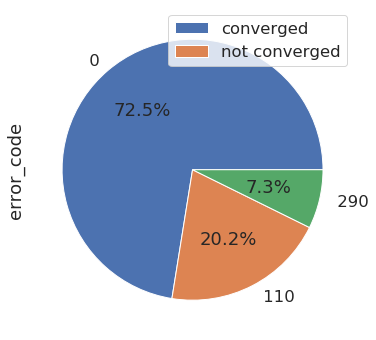

In [29]:
fig = plt.figure(figsize = (10,6))
df['error_code'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
state=['converged', 'not converged']
plt.legend(['converged', 'not converged'])
#plt.legend(loc = 1)

## PCA on setup

We start by performing a Principal Component Analysis (PCA) to reduce dimension. Remember we have 26 features describing
the runs, we want to be able to represent them in 2D for example.

To start with, we are goinf to use only the dataframe from the setup, so mainly using data that come from the run.params
even if we might use some data from the log such as the code version.

We start by working on the data by 
- removing remaining NaN if any, 
- drop some features that have 0 standard deviation,
- convert strings into numerical data,
- perform one-hot-encoding on categorical data.

Now we import packages from scikit-learn to use the well-known PCA model.

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [31]:
df_setup.columns

Index(['params.CFL', 'params.LES_model', 'params.artificial_viscosity_model',
       'params.convection_scheme', 'params.mixture_name', 'params.ncell_group',
       'params.partitioner', 'params.reactive_flow', 'params.real_gas',
       'params.smu2', 'params.solver_type', 'params.two_phase_flow',
       'vars.AVBP_version', 'vars.MPI_processes', 'vars.dimension',
       'vars.nodes', 'vars.number_of_probes'],
      dtype='object')

We create a dataframe for PCA, which we call df_pca and another dataframe, containing also the info of whether the
run converged or not.

In [32]:
df_pca = df[run_setup]
df_pca_c = pd.concat([df[run_setup], df['converged']], axis = 1)
df_pca = df_pca_c

In [33]:
df_pca.head()

params.CFL params.LES_model params.artificial_viscosity_model  \
index_run                                                                 
0           70000000            sigma                             colin   
1           70000000              DNS                                no   
2           00000000             wale                     colin_species   
3           70000000             wale                     colin_species   
5           70000000            sigma                        colin_rhou   

          params.convection_scheme params.mixture_name  params.ncell_group  \
index_run                                                                    
0                             TTGC          KERO_LUCHE                 100   
1                               LW                 AIR                 100   
2                             TTGC          KERO_LUCHE                 100   
3                             TTGC                C3H8                  60   
5                               LW                 AIR                 100   

          params.partitioner  params.reactive_flow  params.real_gas  \
index_run                                                             
0                   parmetis                     1              0.0   
1                   parmetis                     0              0.0   
2                   parmetis                     1              0.0   
3                   parmetis                     1              0.0   
5                   parmetis                     0              0.0   

           params.smu2 params.solver_type  params.two_phase_flow  \
index_run                                                          
0                  1.0                 ns                    0.0   
1                  0.0                 ns                    0.0   
2                  1.0                 ns                    0.0   
3                  0.0                 ns                    0.0   
5                  0.0                 ns                    0.0   

          vars.AVBP_version  vars.MPI_processes  vars.dimension  vars.nodes  \
index_run                                                                     
0                     7.3.0                 360               3     8064050   
1                     7.3.0                  24               2       24576   
2                     7.3.0                1120               3     8043365   
3                     7.6.0                 540               3     3452844   
5                     7.3.0                   2               3        9704   

           vars.number_of_probes  converged  
index_run                                    
0                          122.0          1  
1                            0.0          1  
2                            3.0          1  
3                           72.0          1  
5                            1.0          0

In [34]:
#On supprime les colonnes qui n'ont aucune variabilité.
df_pca = df_pca.drop('params.solver_type', axis = 1)
df_pca = df_pca.drop('params.partitioner', axis = 1)
df_pca = df_pca.drop('params.CFL', axis = 1)

In [35]:
# One-hot encoding of categorical data

In [36]:
dummies_mixturename = pd.get_dummies(df_pca['params.mixture_name'])
df_pca = pd.concat([df_pca.drop('params.mixture_name', axis = 1), dummies_mixturename], axis=1)

dummies_avbpversion = pd.get_dummies(df_pca['vars.AVBP_version'])
df_pca = pd.concat([df_pca.drop('vars.AVBP_version', axis = 1), dummies_avbpversion], axis=1)

dummies_viscoartif = pd.get_dummies(df_pca['params.artificial_viscosity_model'])
df_pca = pd.concat([df_pca.drop('params.artificial_viscosity_model', axis = 1), dummies_viscoartif], axis=1)
#'params.convection_scheme'
dummies_convection_scheme = pd.get_dummies(df_pca['params.convection_scheme'])
df_pca = pd.concat([df_pca.drop('params.convection_scheme', axis = 1), dummies_convection_scheme], axis=1)
                                    
#'params.LES_model'
dummies_LES_model = pd.get_dummies(df_pca['params.LES_model'])
df_pca = pd.concat([df_pca.drop('params.LES_model', axis = 1), dummies_LES_model], axis=1)                                                       
#                       

In [37]:
df_pca = df_pca.dropna()

In [38]:
# on peut supprimer le nombre de probes si on pense que on ne veut pas classer par rapport à cette variable
df_pca = df_pca.drop('vars.number_of_probes', axis = 1)

In [39]:
df_pca_c = df_pca
df_pca = df_pca.drop('converged', axis = 1)

In [40]:
print(len(df_pca_c))

178


In [41]:
print("We have a dataframe that contains", len(df_pca_c), "runs and", len(df_pca.columns), "features \
     that we want to boil down to 2 with the PCA: ")

We have a dataframe that contains 178 runs and 45 features      that we want to boil down to 2 with the PCA: 


In [42]:
df_pca.columns

Index(['params.ncell_group', 'params.reactive_flow', 'params.real_gas',
       'params.smu2', 'params.two_phase_flow', 'vars.MPI_processes',
       'vars.dimension', 'vars.nodes', '1S_C3H8_BFER', '2S_propane', 'AIR',
       'AIR_QPF_Vortex', 'C3H8', 'C3H8_22_173_12_FC', 'C3H8_23_274_10_PP',
       'CH4', 'CH4_19_184_11_LU', 'CH4_53_634_0_GRI', 'CH4_LU_19',
       'KERO_LUCHE', 'N2_qpf', 'N2_qpf_poiseuille', 'N2_qpf_poiseuille_2D',
       '7.1.0', '7.2.0', '7.3.0', '7.4.0', '7.5.0', '7.6.0', 'Jameson',
       'colin', 'colin_rhou', 'colin_rhou_species', 'colin_species', 'honey',
       'jameson', 'no', 'LW', 'LW_FE', 'TTG4A', 'TTGC', 'DNS', 'sigma',
       'smago', 'wale'],
      dtype='object')

In [43]:
print(len(df_pca), len(df_pca_c))

178 178


Now we have a dataframe containing only numerical values, with no null values.

In [44]:
#we create an instance of PCA: we want to determine how many PCA components
#allow to keep 80 % of the standard deviation of the data
pca = PCA(n_components = 7)
# standardScaler, for each variable, withdraws the mean value and divides by std()
scaler = StandardScaler()
scaler.fit(df_pca)
scaled_data = scaler.transform(df_pca)
scaled_data

array([[ 1.01768768,  0.6686961 ,  0.        , ...,  1.51535352,
        -0.4135851 , -0.28069179],
       [ 1.01768768, -1.49544764,  0.        , ..., -0.65991202,
        -0.4135851 , -0.28069179],
       [ 1.01768768,  0.6686961 ,  0.        , ..., -0.65991202,
        -0.4135851 ,  3.56262652],
       ...,
       [ 1.01768768,  0.6686961 ,  0.        , ...,  1.51535352,
        -0.4135851 , -0.28069179],
       [-0.58539557, -1.49544764,  0.        , ..., -0.65991202,
        -0.4135851 , -0.28069179],
       [-0.58539557,  0.6686961 ,  0.        , ..., -0.65991202,
        -0.4135851 , -0.28069179]])

We fit the model on the scaled data:

In [45]:
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [46]:
len(pca.explained_variance_ratio_)

7

we create an instance of PCA: we want to determine how many PCA components
allow to keep 80 % of the standard deviation of the data

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Standard Deviation kept (%)')

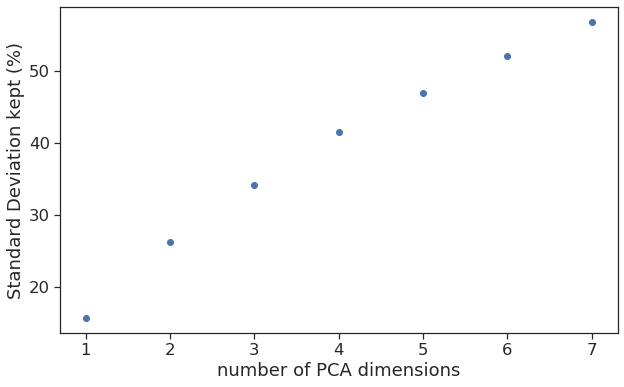

In [47]:
fig = plt.figure(figsize=(10,6))
plt.scatter(np.arange(1,8), 100*pca.explained_variance_ratio_.cumsum())
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('number of PCA dimensions')
ax.set_ylabel('Standard Deviation kept (%)')

#### We now know that we need about 3 or 4 elements in PCA to keep the standard deviation.

## PCA with 2 components

In [48]:
pca = PCA(n_components = 2)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)
#scores_pca
df_comp = pd.concat([df_pca.reset_index(drop = True),
                     pd.DataFrame(scores_pca, 
                     columns = ['Component 1', 'Component 2'])], axis = 1)

In [49]:
df_comp

params.ncell_group  params.reactive_flow  params.real_gas  params.smu2  \
0                   100                     1              0.0          1.0   
1                   100                     0              0.0          0.0   
2                   100                     1              0.0          1.0   
3                    60                     1              0.0          0.0   
4                   100                     0              0.0          0.0   
5                   100                     1              0.0          1.0   
6                   100                     1              0.0          1.0   
7                   100                     0              0.0          0.0   
8                   100                     1              0.0          1.0   
9                   100                     0              0.0          0.0   
10                   40                     1              0.0          0.0   
11                   60                     1              0.0          0.0   
12                   40                     1              0.0          0.0   
13                   40                     1              0.0          0.0   
14                  100                     1              0.0          1.0   
15                  100                     0              0.0          0.0   
16                   60                     1              0.0          0.0   
17                   40                     1              0.0          0.0   
18                   40                     1              0.0          0.0   
19                  100                     1              0.0          1.0   
20                   40                     1              0.0          0.0   
21                   40                     1              0.0          1.0   
22                   40                     1              0.0          0.0   
23                  100                     1              0.0          1.0   
24                  100                     0              0.0          0.0   
25                   40                     0              0.0          0.0   
26                   40                     1              0.0          0.0   
27                   40                     0              0.0          0.0   
28                   40                     0              0.0          0.0   
29                   40                     1              0.0          0.0   
..                  ...                   ...              ...          ...   
148                 100                     1              0.0          1.0   
149                  40                     1              0.0          1.0   
150                 100                     1              0.0          1.0   
151                 100                     1              0.0          1.0   
152                  40                     1              0.0          0.0   
153                  40                     0              0.0          0.0   
154                 100                     1              0.0          1.0   
155                  40                     1              0.0          0.0   
156                  40                     1              0.0          0.0   
157                 100                     0              0.0          0.0   
158                 100                     1              0.0          1.0   
159                  40                     1              0.0          1.0   
160                  40                     0              0.0          0.0   
161                  40                     1              0.0          0.0   
162                  40                     0              0.0          0.0   
163                  40                     1              0.0          1.0   
164                 100                     0              0.0          0.0   
165                 100                     0              0.0          0.0   
166                 100                     1          

In [50]:
df_pca.columns

Index(['params.ncell_group', 'params.reactive_flow', 'params.real_gas',
       'params.smu2', 'params.two_phase_flow', 'vars.MPI_processes',
       'vars.dimension', 'vars.nodes', '1S_C3H8_BFER', '2S_propane', 'AIR',
       'AIR_QPF_Vortex', 'C3H8', 'C3H8_22_173_12_FC', 'C3H8_23_274_10_PP',
       'CH4', 'CH4_19_184_11_LU', 'CH4_53_634_0_GRI', 'CH4_LU_19',
       'KERO_LUCHE', 'N2_qpf', 'N2_qpf_poiseuille', 'N2_qpf_poiseuille_2D',
       '7.1.0', '7.2.0', '7.3.0', '7.4.0', '7.5.0', '7.6.0', 'Jameson',
       'colin', 'colin_rhou', 'colin_rhou_species', 'colin_species', 'honey',
       'jameson', 'no', 'LW', 'LW_FE', 'TTG4A', 'TTGC', 'DNS', 'sigma',
       'smago', 'wale'],
      dtype='object')

In [51]:
df_pcacomponents = pd.DataFrame(abs(pca.components_), columns = df_pca.columns)
df_pcacomponents

params.ncell_group  params.reactive_flow  params.real_gas  params.smu2  \
0            0.149212              0.136460     1.110223e-16     0.317248   
1            0.168670              0.267144     2.775558e-17     0.076383   

   params.two_phase_flow  vars.MPI_processes  vars.dimension  vars.nodes  \
0           1.387779e-17            0.246221        0.297834    0.335350   
1           5.551115e-17            0.081114        0.081247    0.042657   

   1S_C3H8_BFER  2S_propane  ...   jameson        no        LW     LW_FE  \
0      0.016811    0.012067  ...  0.111498  0.236210  0.118011  0.176057   
1      0.047664    0.035659  ...  0.025801  0.224158  0.302733  0.263192   

      TTG4A      TTGC       DNS     sigma     smago      wale  
0  0.086792  0.279656  0.301164  0.272627  0.029459  0.136452  
1  0.001091  0.106964  0.195794  0.006356  0.294086  0.012081  

[2 rows x 45 columns]

Text(106.5, 0.5, "['PCA Componant 1', 'PCA Componant 2']")

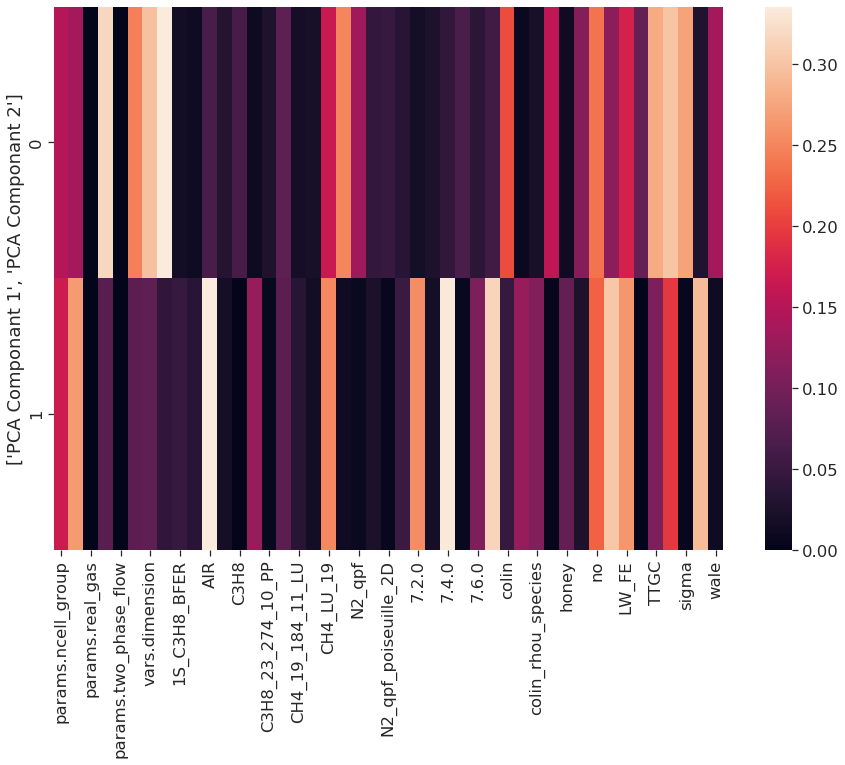

In [52]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1)
sns.heatmap(df_pcacomponents)
ax.set_ylabel(['PCA Componant 1', 'PCA Componant 2'])

In [53]:
np.transpose(pca.components_)

array([[ 1.49212324e-01,  1.68669660e-01],
       [ 1.36460308e-01, -2.67144277e-01],
       [-1.11022302e-16, -2.77555756e-17],
       [ 3.17247638e-01, -7.63830397e-02],
       [-1.38777878e-17,  5.55111512e-17],
       [ 2.46220831e-01, -8.11141060e-02],
       [ 2.97833669e-01,  8.12471175e-02],
       [ 3.35350082e-01, -4.26566728e-02],
       [-1.68114569e-02,  4.76637213e-02],
       [-1.20665603e-02,  3.56593402e-02],
       [-6.51005232e-02,  3.34803459e-01],
       [-3.15872814e-02,  1.88012512e-02],
       [ 6.32296511e-02, -1.40998721e-03],
       [ 1.06171464e-02,  1.27040609e-01],
       [-2.63625409e-02,  7.46717007e-03],
       [ 8.19113767e-02, -8.03484189e-02],
       [-1.96279571e-02, -3.65062105e-02],
       [-2.09884398e-02, -1.64046900e-02],
       [-1.65823477e-01, -2.51521099e-01],
       [ 2.50305471e-01, -1.36412708e-02],
       [-1.33279481e-01,  8.51197865e-03],
       [-4.48365118e-02,  2.41371791e-02],
       [-4.93130905e-02,  5.67310093e-03],
       [-3.

In [54]:
df_pca.columns[0]

'params.ncell_group'

In [55]:
def biplot(scores_pca, coeff):
    
    x = scores_pca[:,0] # projection on PC1
    print(x)
    y = scores_pca[:,1] # projection on PC2
    print(y)
    
    n = coeff.shape[0] # number of variables
    print(n)
    plt.figure(figsize=(10,8), dpi=100)

    colors = ['g','r','y']
    markers=['o','^','x']

    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0.0, 0.0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.9,
                  linestyle = '-',linewidth = 1.1, overhang=0.2)
        plt.text(coeff[i,0]*1.01, coeff[i,1]*1.01, df_pca.columns[i], 
                 color = 'k', ha = 'center', va = 'center',fontsize=10)
        
    plt.xlabel("PCA Component{}".format(1), size=14)
    plt.ylabel("PCA Component{}".format(2), size=14)
#    limx= int(x.max())
#    limy= int(y.max())
    plt.xlim([-0.4,0.4])
    plt.ylim([-0.4,0.4])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

[ 4.08934916 -2.4805087   4.77730141  2.27583201 -0.29350831  4.08934916
  2.94971353 -2.16194432  2.94971353 -0.43232083 -2.77615331  3.36940283
 -2.02957775 -2.77615331  3.19355879  0.65114861  3.56276828 -2.04781263
 -0.92651725  4.08934916 -1.78757111  2.68316339 -0.92651725  4.08705374
 -1.35236816 -1.79498191 -2.686802   -2.84490853 -2.12924482 -2.77615331
 -1.29146096 -1.07947122  3.29613144 -0.79088754  3.29613144 -1.29146096
 -1.22198237  4.92615854 -0.20901562  4.08934916  2.94971353  1.22659059
 -2.82822594  0.95169469 -3.21886277  3.96898927 -2.30728179  0.38347017
 -2.77615331 -1.2379046  -2.60260151 -2.77615331 -2.90862019  2.68316339
 -0.9082164  -2.30728179  2.62010868 -1.23823647 -2.77615331 -2.77615331
  2.68316339  0.5323273  -1.30581149 -3.08481377  0.60077381  4.08705374
 -0.92651725 -1.02783809 -0.9082164   3.79173402  1.65826343 -2.77615331
 -2.45896037 -1.90962572 -2.12924482 -1.90962572 -0.79088754 -2.69576591
 -3.17872622 -0.88594818 -2.59714727  1.22659059  2

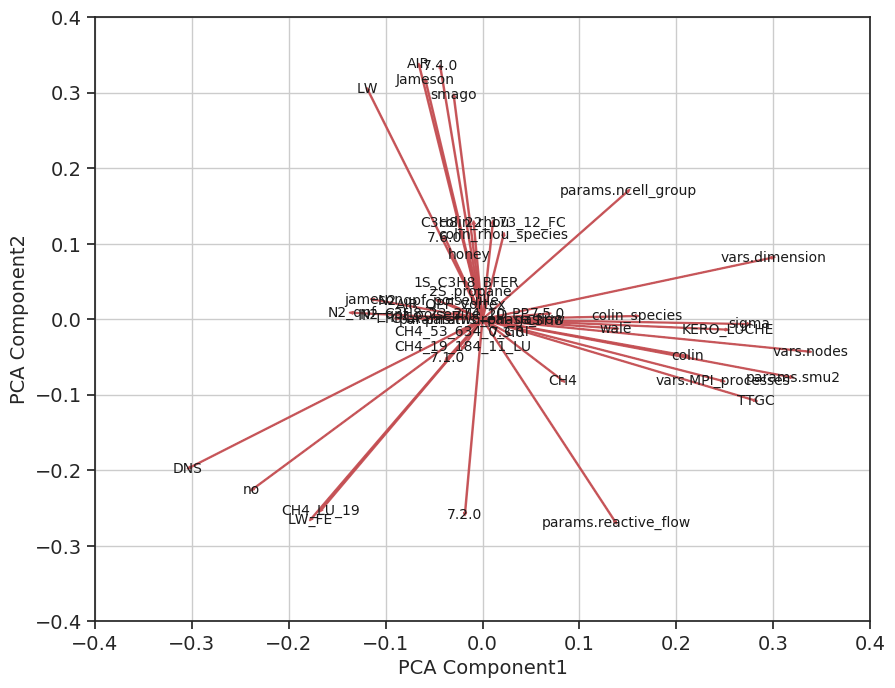

In [56]:
biplot(scores_pca, np.transpose(pca.components_))
plt.show()

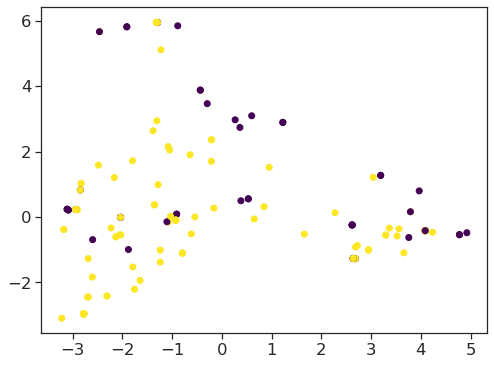

In [57]:
fig = plt.figure(figsize = (8,6))

plt.scatter(scores_pca[:,0], scores_pca[:,1], 
            c = df_pca_c['converged'], cmap = 'viridis')

## Determination du nombre de clusters optimal

In [58]:
from sklearn.cluster import KMeans

In [59]:
# on ne connait pas au préalable le nombre de clusters dans les runs
#on va maintenant montrer que le nombre de cluster optimal est bien 3
# Inertia is the sum of squared distances of samples to their closest cluster centre avec la donnée kmeans.inertia_

distance = []
for i in range(1,6):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(scores_pca)
    distance.append(kmeans.inertia_)

Text(0, 0.5, 'kmeans distance')

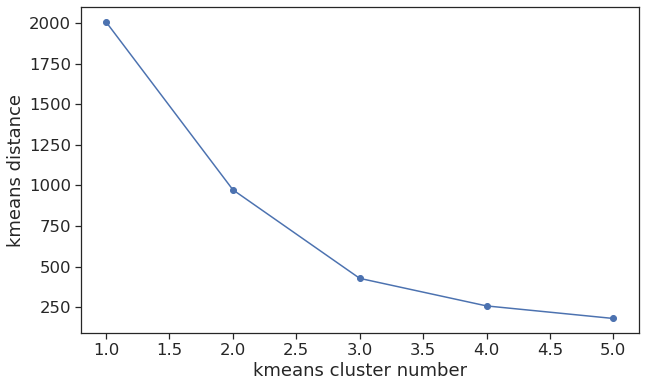

In [60]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1, 1)
plt.plot(range(1,6), distance, '-o')
ax.set_xlabel('kmeans cluster number')
ax.set_ylabel('kmeans distance')

We see that above 3 clusters in the kmeans model doesn't make the distance drop so much, so 3 is the optimal value.
We can deduce here that we have 3 big tendencies in our runs.

## Kmeans with 3 clusters 

In [61]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[0 1 0 0 2 0 0 1 0 2 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 2 1 1 1 1 2 2 0 1 0 2 2
 0 2 0 0 2 1 2 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 2 1 2 0 1 1 1 0 0 1 2 2
 1 2 1 1 1 2 1 2 0 2 1 1 2 1 0 2 0 1 2 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1
 1 1 1 1 2 1 1 2 0 1 0 2 1 0 0 1 0 0 0 1 1 1 0 1 1 2 1 2 1 0 0 0 2 1 1 1 0
 0 0 0 0 1 1 0 1 1 2 0 0 1 2 1 0 1 2 0 0 1 1 1 1 1 0 1 0 1 1]


In [62]:
kmeans.cluster_centers_.shape

(3, 2)

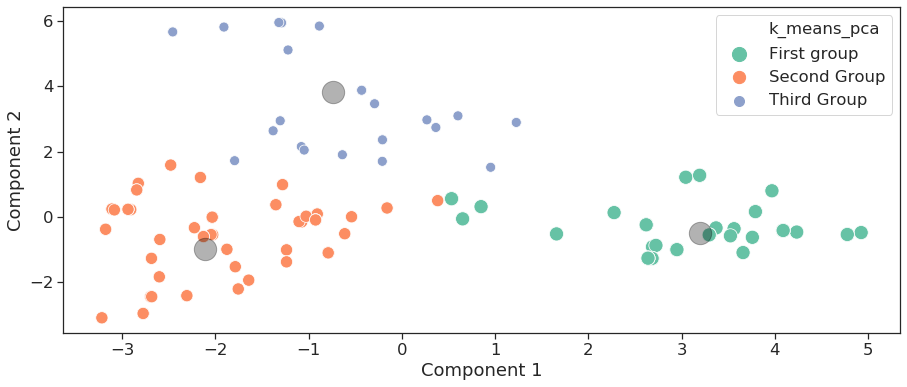

In [63]:
#ax = sns.scatterplot(x="total_bill", y="tip",
#                     hue="size", size="size",
##                     sizes=(20, 200), hue_norm=(0, 7),
#                     legend="full", data=tips)
# With 2 components in PCA and kmeans = 4
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group'})
fig = plt.figure(figsize = (15,6))
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
#                palette = ['g', 'r', 'b'])

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], size = df_comp['k_means_pca'],
                sizes= (100,200), palette="Set2")
#sns.scatterplot(x, y, hue = df_pca_c['converged'], 
#                palette="Set1", alpha = 0.4)
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 500, c='black', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 500, c='black', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 500, c='black', label = 'Centroids', alpha = 0.3)

In [64]:
df_process_mean = df_comp.groupby('k_means_pca').mean()
df_process_mean

params.ncell_group  params.reactive_flow  params.real_gas  \
k_means_pca                                                               
First group            77.460317              0.888889              0.0   
Second Group           43.058824              0.682353              0.0   
Third Group            82.666667              0.300000              0.0   

              params.smu2  params.two_phase_flow  vars.MPI_processes  \
k_means_pca                                                            
First group      0.793651                    0.0          523.301587   
Second Group     0.000000                    0.0          101.411765   
Third Group      0.000000                    0.0           94.400000   

              vars.dimension    vars.nodes  1S_C3H8_BFER  2S_propane  ...  \
k_means_pca                                                           ...   
First group         2.968254  5.395026e+06      0.000000    0.000000  ...   
Second Group        2.082353  2.129932e+05      0.011765    0.000000  ...   
Third Group         2.633333  8.879764e+05      0.066667    0.033333  ...   

                    LW     LW_FE     TTG4A      TTGC       DNS     sigma  \
k_means_pca                                                                
First group   0.095238  0.000000  0.000000  0.904762  0.015873  0.714286   
Second Group  0.423529  0.329412  0.070588  0.176471  0.964706  0.000000   
Third Group   0.966667  0.000000  0.000000  0.033333  0.066667  0.300000   

                 smago      wale  Component 1  Component 2  
k_means_pca                                                 
First group   0.079365  0.190476     3.202650    -0.500241  
Second Group  0.035294  0.000000    -2.112983    -0.980037  
Third Group   0.600000  0.033333    -0.738779     3.827278  

[3 rows x 47 columns]

In [65]:
df_comp2 = df_comp.drop(['params.reactive_flow','params.real_gas', 
                                            'params.two_phase_flow', 'Component 1', 
                                            'Component 2'], axis = 1)

In [66]:
df_process_std = df_comp2.groupby('k_means_pca').std()

In [67]:
dataframe = pd.concat([df_comp2[df_comp2['k_means_pca'] == 'First group'].mean(), 
                       df_comp2[df_comp2['k_means_pca'] == 'First group'].std(),
                       df_comp2[df_comp2['k_means_pca'] == 'Second Group'].mean(), 
                       df_comp2[df_comp2['k_means_pca'] == 'Second Group'].std(),
                       df_comp2[df_comp2['k_means_pca'] == 'Third Group'].mean(), 
                       df_comp2[df_comp2['k_means_pca'] == 'Third Group'].std()], axis = 1) 
dataframe.columns =  ['Mean First group', 'Std First Group', 
                      'Mean Second group', 'Std Second Group',
                      'Mean Third group', 'Std Third Group']
dataframe.sort_values(by ='Mean Third group', ascending = False)

Mean First group  Std First Group  Mean Second group  \
vars.nodes                5.395026e+06     2.788766e+06      212993.223529   
vars.MPI_processes        5.233016e+02     3.393942e+02         101.411765   
params.ncell_group        7.746032e+01     2.699870e+01          43.058824   
vars.dimension            2.968254e+00     1.767314e-01           2.082353   
LW                        9.523810e-02     2.959013e-01           0.423529   
smago                     7.936508e-02     2.724789e-01           0.035294   
AIR                       0.000000e+00     0.000000e+00           0.011765   
7.4.0                     0.000000e+00     0.000000e+00           0.011765   
Jameson                   0.000000e+00     0.000000e+00           0.000000   
sigma                     7.142857e-01     4.553826e-01           0.000000   
7.6.0                     1.587302e-02     1.259882e-01           0.058824   
colin                     7.619048e-01     4.293388e-01           0.258824   
colin_rhou_species        0.000000e+00     0.000000e+00           0.000000   
C3H8_22_173_12_FC         0.000000e+00     0.000000e+00           0.000000   
CH4                       4.285714e-01     4.988466e-01           0.235294   
colin_rhou                0.000000e+00     0.000000e+00           0.000000   
7.3.0                     4.126984e-01     4.962739e-01           0.447059   
DNS                       1.587302e-02     1.259882e-01           0.964706   
1S_C3H8_BFER              0.000000e+00     0.000000e+00           0.011765   
honey                     0.000000e+00     0.000000e+00           0.000000   
no                        0.000000e+00     0.000000e+00           0.588235   
7.5.0                     1.904762e-01     3.958308e-01           0.105882   
TTGC                      9.047619e-01     2.959013e-01           0.176471   
7.2.0                     3.809524e-01     4.895215e-01           0.364706   
wale                      1.904762e-01     3.958308e-01           0.000000   
2S_propane                0.000000e+00     0.000000e+00           0.000000   
C3H8_23_274_10_PP         0.000000e+00     0.000000e+00           0.011765   
7.1.0                     0.000000e+00     0.000000e+00           0.011765   
AIR_QPF_Vortex            0.000000e+00     0.000000e+00           0.035294   
C3H8                      1.587302e-01     3.683594e-01           0.058824   
TTG4A                     0.000000e+00     0.000000e+00           0.070588   
LW_FE                     0.000000e+00     0.000000e+00           0.329412   
CH4_19_184_11_LU          0.000000e+00     0.000000e+00           0.011765   
params.smu2               7.936508e-01     4.457227e-01           0.000000   
jameson                   0.000000e+00     0.000000e+00           0.152941   
CH4_LU_19                 0.000000e+00     0.000000e+00           0.352941   
colin_species             2.380952e-01     4.293388e-01           0.000000   
KERO_LUCHE                4.126984e-01     4.962739e-01           0.000000   
N2_qpf                    0.000000e+00     0.000000e+00           0.211765   
N2_qpf_poiseuille         0.000000e+00     0.000000e+00           0.023529   
N2_qpf_poiseuille_2D      0.000000e+00     0.000000e+00           0.023529   
CH4_53_634_0_GRI          0.000000e+00     0.000000e+00           0.011765   

                      Std Second Group  Mean Third group  Std Third Group  
vars.nodes               481554.059084     887976.400000     1.798637e+06  
vars.MPI_processes          101.135493         94.400000     2.027417e+02  
params.ncell_group           12.912114         82.666667     6.741193e+01  
vars.dimension                0.352264          2.633333     6.149479e-01  
LW                            0.497050          0.966667     1.825742e-01  
smago                         0.185617          0.600000     4.982729e-01  
AIR                           0.108465          0.566667     5.040069e-01  
7.4.0                         0.108465          0.566667   

In [68]:
dataframe = pd.concat([df_comp2[df_comp2['k_means_pca'] == 'First group'].std(), 
             df_comp2[df_comp2['k_means_pca'] == 'Second Group'].std(), 
             df_comp2[df_comp2['k_means_pca'] == 'Third Group'].std()], axis = 1) 
dataframe.columns =  ['First group', 'Second group', 'Third group']
dataframe

First group   Second group   Third group
params.ncell_group    2.699870e+01      12.912114  6.741193e+01
params.smu2           4.457227e-01       0.000000  0.000000e+00
vars.MPI_processes    3.393942e+02     101.135493  2.027417e+02
vars.dimension        1.767314e-01       0.352264  6.149479e-01
vars.nodes            2.788766e+06  481554.059084  1.798637e+06
1S_C3H8_BFER          0.000000e+00       0.108465  2.537081e-01
2S_propane            0.000000e+00       0.000000  1.825742e-01
AIR                   0.000000e+00       0.108465  5.040069e-01
AIR_QPF_Vortex        0.000000e+00       0.185617  0.000000e+00
C3H8                  3.683594e-01       0.236691  0.000000e+00
C3H8_22_173_12_FC     0.000000e+00       0.000000  3.790490e-01
C3H8_23_274_10_PP     0.000000e+00       0.108465  1.825742e-01
CH4                   4.988466e-01       0.426700  3.457459e-01
CH4_19_184_11_LU      0.000000e+00       0.108465  0.000000e+00
CH4_53_634_0_GRI      0.000000e+00       0.108465  0.000000e+00
CH4_LU_19             0.000000e+00       0.480721  0.000000e+00
KERO_LUCHE            4.962739e-01       0.000000  0.000000e+00
N2_qpf                0.000000e+00       0.410984  0.000000e+00
N2_qpf_poiseuille     0.000000e+00       0.152477  0.000000e+00
N2_qpf_poiseuille_2D  0.000000e+00       0.152477  0.000000e+00
7.1.0                 0.000000e+00       0.108465  0.000000e+00
7.2.0                 4.895215e-01       0.484204  1.825742e-01
7.3.0                 4.962739e-01       0.500140  3.051286e-01
7.4.0                 0.000000e+00       0.108465  5.040069e-01
7.5.0                 3.958308e-01       0.309513  1.825742e-01
7.6.0                 1.259882e-01       0.236691  4.497764e-01
Jameson               0.000000e+00       0.000000  4.794633e-01
colin                 4.293388e-01       0.440588  4.497764e-01
colin_rhou            0.000000e+00       0.000000  3.457459e-01
colin_rhou_species    0.000000e+00       0.000000  4.068381e-01
colin_species         4.293388e-01       0.000000  0.000000e+00
honey                 0.000000e+00       0.000000  1.825742e-01
jameson               0.000000e+00       0.362067  0.000000e+00
no                    0.000000e+00       0.495074  1.825742e-01
LW                    2.959013e-01       0.497050  1.825742e-01
LW_FE                 0.000000e+00       0.472789  0.000000e+00
TTG4A                 0.000000e+00       0.257656  0.000000e+00
TTGC                  2.959013e-01       0.383482  1.825742e-01
DNS                   1.259882e-01       0.185617  2.537081e-01
sigma                 4.553826e-01       0.000000  4.660916e-01
smago                 2.724789e-01       0.185617  4.982729e-01
wale                  3.958308e-01       0.000000  1.825742e-01

In [69]:
df_comp2[df_comp2['k_means_pca'] == 'Second Group'].mean()
df_comp2[df_comp2['k_means_pca'] == 'Second Group'].std()

params.ncell_group          12.912114
params.smu2                  0.000000
vars.MPI_processes         101.135493
vars.dimension               0.352264
vars.nodes              481554.059084
1S_C3H8_BFER                 0.108465
2S_propane                   0.000000
AIR                          0.108465
AIR_QPF_Vortex               0.185617
C3H8                         0.236691
C3H8_22_173_12_FC            0.000000
C3H8_23_274_10_PP            0.108465
CH4                          0.426700
CH4_19_184_11_LU             0.108465
CH4_53_634_0_GRI             0.108465
CH4_LU_19                    0.480721
KERO_LUCHE                   0.000000
N2_qpf                       0.410984
N2_qpf_poiseuille            0.152477
N2_qpf_poiseuille_2D         0.152477
7.1.0                        0.108465
7.2.0                        0.484204
7.3.0                        0.500140
7.4.0                        0.108465
7.5.0                        0.309513
7.6.0                        0.236691
Jameson     

In [70]:
df_comp2[df_comp2['k_means_pca'] == 'Third Group'].mean()
df_comp2[df_comp2['k_means_pca'] == 'Third Group'].std()


params.ncell_group      6.741193e+01
params.smu2             0.000000e+00
vars.MPI_processes      2.027417e+02
vars.dimension          6.149479e-01
vars.nodes              1.798637e+06
1S_C3H8_BFER            2.537081e-01
2S_propane              1.825742e-01
AIR                     5.040069e-01
AIR_QPF_Vortex          0.000000e+00
C3H8                    0.000000e+00
C3H8_22_173_12_FC       3.790490e-01
C3H8_23_274_10_PP       1.825742e-01
CH4                     3.457459e-01
CH4_19_184_11_LU        0.000000e+00
CH4_53_634_0_GRI        0.000000e+00
CH4_LU_19               0.000000e+00
KERO_LUCHE              0.000000e+00
N2_qpf                  0.000000e+00
N2_qpf_poiseuille       0.000000e+00
N2_qpf_poiseuille_2D    0.000000e+00
7.1.0                   0.000000e+00
7.2.0                   1.825742e-01
7.3.0                   3.051286e-01
7.4.0                   5.040069e-01
7.5.0                   1.825742e-01
7.6.0                   4.497764e-01
Jameson                 4.794633e-01
c

In [71]:
df_comp2.groupby('k_means_pca').mean()

params.ncell_group  params.smu2  vars.MPI_processes  \
k_means_pca                                                         
First group            77.460317     0.793651          523.301587   
Second Group           43.058824     0.000000          101.411765   
Third Group            82.666667     0.000000           94.400000   

              vars.dimension    vars.nodes  1S_C3H8_BFER  2S_propane  \
k_means_pca                                                            
First group         2.968254  5.395026e+06      0.000000    0.000000   
Second Group        2.082353  2.129932e+05      0.011765    0.000000   
Third Group         2.633333  8.879764e+05      0.066667    0.033333   

                   AIR  AIR_QPF_Vortex      C3H8  ...   jameson        no  \
k_means_pca                                       ...                       
First group   0.000000        0.000000  0.158730  ...  0.000000  0.000000   
Second Group  0.011765        0.035294  0.058824  ...  0.152941  0.588235   
Third Group   0.566667        0.000000  0.000000  ...  0.000000  0.033333   

                    LW     LW_FE     TTG4A      TTGC       DNS     sigma  \
k_means_pca                                                                
First group   0.095238  0.000000  0.000000  0.904762  0.015873  0.714286   
Second Group  0.423529  0.329412  0.070588  0.176471  0.964706  0.000000   
Third Group   0.966667  0.000000  0.000000  0.033333  0.066667  0.300000   

                 smago      wale  
k_means_pca                       
First group   0.079365  0.190476  
Second Group  0.035294  0.000000  
Third Group   0.600000  0.033333  

[3 rows x 42 columns]

In [72]:
df_comp2.groupby('k_means_pca').std()

params.ncell_group  params.smu2  vars.MPI_processes  \
k_means_pca                                                         
First group            26.998701     0.445723          339.394177   
Second Group           12.912114     0.000000          101.135493   
Third Group            67.411926     0.000000          202.741657   

              vars.dimension    vars.nodes  1S_C3H8_BFER  2S_propane  \
k_means_pca                                                            
First group         0.176731  2.788766e+06      0.000000    0.000000   
Second Group        0.352264  4.815541e+05      0.108465    0.000000   
Third Group         0.614948  1.798637e+06      0.253708    0.182574   

                   AIR  AIR_QPF_Vortex      C3H8  ...   jameson        no  \
k_means_pca                                       ...                       
First group   0.000000        0.000000  0.368359  ...  0.000000  0.000000   
Second Group  0.108465        0.185617  0.236691  ...  0.362067  0.495074   
Third Group   0.504007        0.000000  0.000000  ...  0.000000  0.182574   

                    LW     LW_FE     TTG4A      TTGC       DNS     sigma  \
k_means_pca                                                                
First group   0.295901  0.000000  0.000000  0.295901  0.125988  0.455383   
Second Group  0.497050  0.472789  0.257656  0.383482  0.185617  0.000000   
Third Group   0.182574  0.000000  0.000000  0.182574  0.253708  0.466092   

                 smago      wale  
k_means_pca                       
First group   0.272479  0.395831  
Second Group  0.185617  0.000000  
Third Group   0.498273  0.182574  

[3 rows x 42 columns]

In [73]:
df_comp2.head()

params.ncell_group  params.smu2  vars.MPI_processes  vars.dimension  \
0                 100          1.0                 360               3   
1                 100          0.0                  24               2   
2                 100          1.0                1120               3   
3                  60          0.0                 540               3   
4                 100          0.0                   2               3   

   vars.nodes  1S_C3H8_BFER  2S_propane  AIR  AIR_QPF_Vortex  C3H8  ...  no  \
0     8064050             0           0    0               0     0  ...   0   
1       24576             0           0    1               0     0  ...   1   
2     8043365             0           0    0               0     0  ...   0   
3     3452844             0           0    0               0     1  ...   0   
4        9704             0           0    1               0     0  ...   0   

   LW  LW_FE  TTG4A  TTGC  DNS  sigma  smago  wale   k_means_pca  
0   0      0      0     1    0      1      0     0   First group  
1   1      0      0     0    1      0      0     0  Second Group  
2   0      0      0     1    0      0      0     1   First group  
3   0      0      0     1    0      0      0     1   First group  
4   1      0      0     0    0      1      0     0   Third Group  

[5 rows x 43 columns]

The PCA gives us a hint of how to plot in 2D the plots.
so we know that we can plot runs by colin_species and wale, maybe vars.dimension and ncell group.
so we can also make a pairplot regarding these variables.

## Kmeans with 3 clusters with highlight of converged/not converged

In [74]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[1 0 1 1 2 1 1 0 1 2 0 1 0 0 1 1 1 0 0 1 0 1 0 1 0 2 0 0 0 0 2 2 1 0 1 2 2
 1 2 1 1 2 0 2 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 2 0 2 1 0 0 0 1 1 0 2 2
 0 2 0 0 0 2 0 2 1 2 0 0 2 0 1 2 1 0 2 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0
 0 0 0 0 2 0 0 2 1 0 1 2 0 1 1 0 1 1 1 0 0 0 1 0 0 2 0 2 0 1 1 1 2 0 0 0 1
 1 1 1 1 0 0 1 0 0 2 1 1 0 2 0 1 0 2 1 1 0 0 0 0 0 1 0 1 0 0]


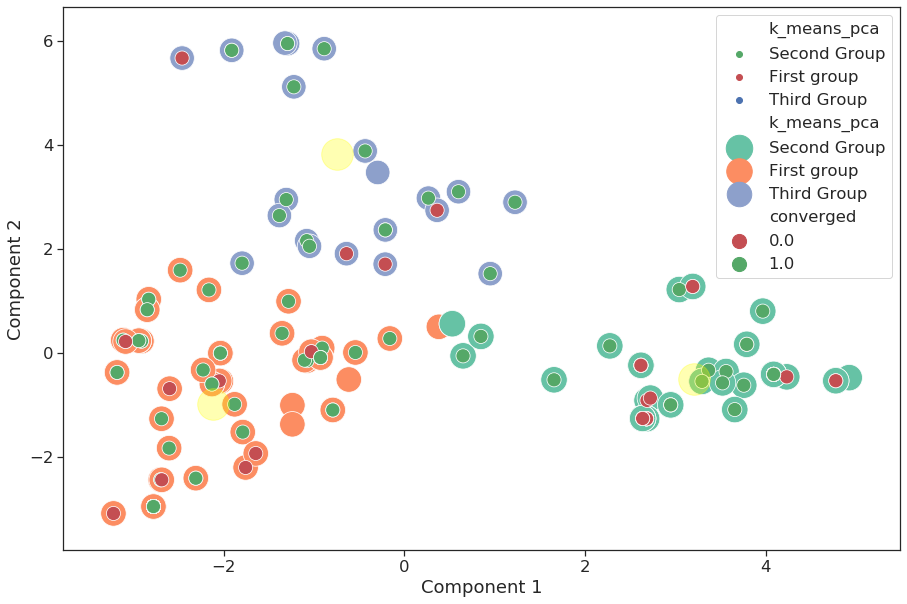

In [75]:
# With 2 components in PCA and kmeans = 4
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group'})
fig = plt.figure(figsize = (15,10))
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
                palette = ['g', 'r', 'b'], alpha = 0.6)

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], 
                size = df_comp['k_means_pca'],
                sizes= (600,700), palette="Set2")

sns.scatterplot(x, y, hue = df_pca_c['converged'], 
                size = df_pca_c['converged'],
               sizes = (200,200), palette = ['r', 'g'])

plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 1000, c='yellow', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 1000, c='yellow', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 1000, c='yellow', label = 'Centroids', alpha = 0.3)


## PCA with 4 components

We know that a PCA with 4 components should optimize the standard deviation kept in the dimension reduction.

In [76]:
## PCA with 4 components
scaler = StandardScaler()
scaler.fit(df_pca)
scaled_data = scaler.transform(df_pca)
scaled_data
pca = PCA(n_components = 4)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)
#scores_pca
df_comp = pd.concat([df_pca.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_comp.columns.values[-4:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']

scores_pca stores the projections of each run in the new frame system.
PCA_components stores the linear coefficients of each PCA component of the original features.

In [77]:
pca4 = pd.DataFrame(abs(pca.components_), columns = df_pca.columns)
pca4['PCA components'] = [0, 1, 2, 3]
pca4.set_index('PCA components')
pca4['KERO_LUCHE']

0    0.250305
1    0.013641
2    0.150608
3    0.001673
Name: KERO_LUCHE, dtype: float64

In [78]:
scores_pca

array([[ 4.08934916e+00, -4.15744832e-01,  1.23882920e+00,
        -1.32377741e+00],
       [-2.48050870e+00,  1.58909545e+00,  9.23783485e-01,
        -1.52349895e-01],
       [ 4.77730141e+00, -5.38349572e-01,  1.91659687e+00,
         3.47444007e+00],
       [ 2.27583201e+00,  1.32338153e-01,  2.32893215e-01,
         5.15803327e+00],
       [-2.93508309e-01,  3.46935758e+00,  5.06256754e-01,
        -1.43181855e+00],
       [ 4.08934916e+00, -4.15744832e-01,  1.23882920e+00,
        -1.32377741e+00],
       [ 2.94971353e+00, -1.00275414e+00, -1.06523630e+00,
        -1.99665397e+00],
       [-2.16194432e+00,  1.20990987e+00,  5.39620132e-02,
         1.54936411e-01],
       [ 2.94971353e+00, -1.00275414e+00, -1.06523630e+00,
        -1.99665397e+00],
       [-4.32320834e-01,  3.88338219e+00, -5.94023272e-01,
        -1.09751459e+00],
       [-2.77615331e+00, -2.95904098e+00, -1.75241751e+00,
         4.55883166e-01],
       [ 3.36940283e+00, -3.36451010e-01,  5.30265059e-01,
      

for the first component of PCA, we can see that the most important features are params.ncell_group, params.smu2, vars.MPI_processes, vars.dimension, vars.nodes and AIR.

In [79]:
def biplot4(scores_pca, coeff):
    
    x = scores_pca[:,0] # projection on PC1
    print(x)
    y = scores_pca[:,1] # projection on PC2
    print(y)
    
    
    n = coeff.shape[0] # number of variables
    print(n)
    plt.figure(figsize=(10,8), dpi=100)

    colors = ['g','r','y']
    markers=['o','^','x']

    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0.0, 0.0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.9,
                  linestyle = '-',linewidth = 1.1, overhang=0.2)
        plt.text(coeff[i,0]*1.01, coeff[i,1]*1.01, df_pca.columns[i], 
                 color = 'k', ha = 'center', va = 'center',fontsize=10)
        
    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
#    limx= int(x.max())
#    limy= int(y.max())
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.5,0.5])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

[ 4.08934916 -2.4805087   4.77730141  2.27583201 -0.29350831  4.08934916
  2.94971353 -2.16194432  2.94971353 -0.43232083 -2.77615331  3.36940283
 -2.02957775 -2.77615331  3.19355879  0.65114861  3.56276828 -2.04781263
 -0.92651725  4.08934916 -1.78757111  2.68316339 -0.92651725  4.08705374
 -1.35236816 -1.79498191 -2.686802   -2.84490853 -2.12924482 -2.77615331
 -1.29146096 -1.07947122  3.29613144 -0.79088754  3.29613144 -1.29146096
 -1.22198237  4.92615854 -0.20901562  4.08934916  2.94971353  1.22659059
 -2.82822594  0.95169469 -3.21886277  3.96898927 -2.30728179  0.38347017
 -2.77615331 -1.2379046  -2.60260151 -2.77615331 -2.90862019  2.68316339
 -0.9082164  -2.30728179  2.62010868 -1.23823647 -2.77615331 -2.77615331
  2.68316339  0.5323273  -1.30581149 -3.08481377  0.60077381  4.08705374
 -0.92651725 -1.02783809 -0.9082164   3.79173402  1.65826343 -2.77615331
 -2.45896037 -1.90962572 -2.12924482 -1.90962572 -0.79088754 -2.69576591
 -3.17872622 -0.88594818 -2.59714727  1.22659059  2

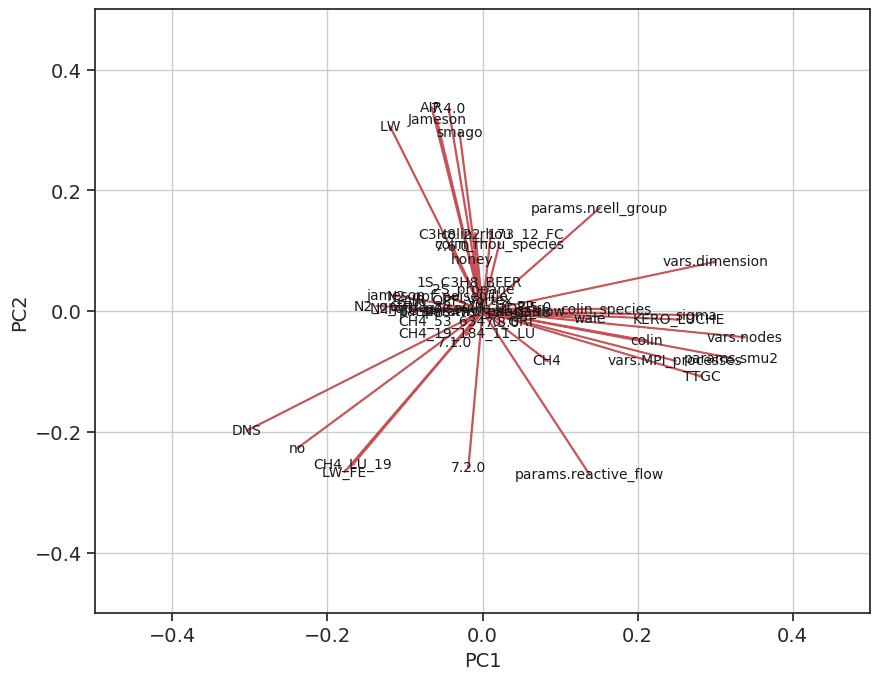

In [80]:
biplot4(scores_pca, np.transpose(pca.components_))
plt.show()

In [81]:
def biplot4(scores_pca, coeff):
    
    x = scores_pca[:,2] # projection on PC1
    print(x)
    y = scores_pca[:,3] # projection on PC2
    print(y)
    
    
    n = coeff.shape[0] # number of variables
    print(n)
    plt.figure(figsize=(10,8), dpi=100)

    colors = ['g','r','y']
    markers=['o','^','x']

    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0.0, 0.0, coeff[i,2], coeff[i,3], color = 'r', alpha = 0.9,
                  linestyle = '-',linewidth = 1.1, overhang=0.2)
        plt.text(coeff[i,2]*1.01, coeff[i,3]*1.01, df_pca.columns[i], 
                 color = 'k', ha = 'center', va = 'center',fontsize=10)
        
    plt.xlabel("PC{}".format(3), size=14)
    plt.ylabel("PC{}".format(4), size=14)
#    limx= int(x.max())
#    limy= int(y.max())
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.5,0.5])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

[ 1.2388292   0.92378348  1.91659687  0.23289321  0.50625675  1.2388292
 -1.0652363   0.05396201 -1.0652363  -0.59402327 -1.75241751  0.53026506
  0.32895501 -1.75241751 -0.08893726 -0.78553582  0.56702712  0.3299083
 -0.66437573  1.2388292   0.80589611 -1.14198721 -0.66437573  1.2383928
  0.38903683  0.80238937 -1.31425225  3.86046476  2.62910868 -1.75241751
 -1.7539699  -1.68168521  0.41106176 -1.49571467  0.41106176 -1.7539699
 -2.33076512  0.97453696 -2.00358732  1.2388292  -1.0652363  -2.23763998
  3.83125843 -1.43280145 -1.64720621  1.8016174  -1.52995545  0.32651592
 -1.75241751 -1.53730337 -1.03784222 -1.75241751  2.29254274 -1.14198721
 -0.28917627 -1.52995545  0.38781149  0.66498311 -1.75241751 -1.75241751
 -1.14198721 -0.61554399  1.28211034  5.58948295 -2.2055331   1.2383928
 -0.66437573  0.6514099  -0.28917627  1.73050603 -0.75991989 -1.75241751
 -1.4713668  -1.6122798   2.62910868 -1.6122798  -1.49571467 -0.29053234
  4.02305206 -1.73473747  0.47082129 -2.23763998 -1.1502

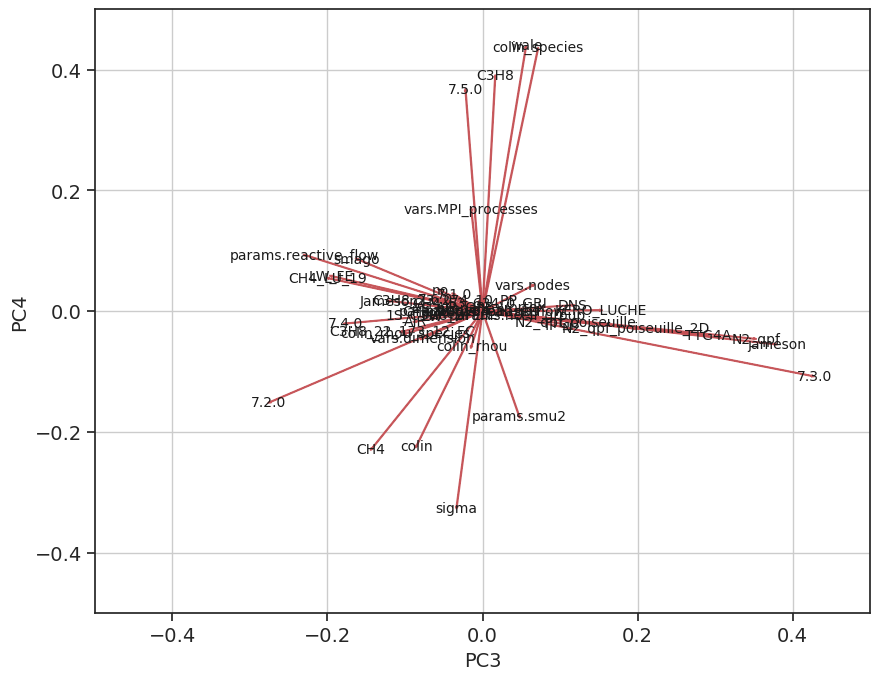

In [82]:
biplot4(scores_pca, np.transpose(pca.components_))
plt.show()

In [83]:
df_comp.head()

params.ncell_group  params.reactive_flow  params.real_gas  params.smu2  \
0                 100                     1              0.0          1.0   
1                 100                     0              0.0          0.0   
2                 100                     1              0.0          1.0   
3                  60                     1              0.0          0.0   
4                 100                     0              0.0          0.0   

   params.two_phase_flow  vars.MPI_processes  vars.dimension  vars.nodes  \
0                    0.0                 360               3     8064050   
1                    0.0                  24               2       24576   
2                    0.0                1120               3     8043365   
3                    0.0                 540               3     3452844   
4                    0.0                   2               3        9704   

   1S_C3H8_BFER  2S_propane  ...  TTG4A  TTGC  DNS  sigma  smago  wale  \
0             0           0  ...      0     1    0      1      0     0   
1             0           0  ...      0     0    1      0      0     0   
2             0           0  ...      0     1    0      0      0     1   
3             0           0  ...      0     1    0      0      0     1   
4             0           0  ...      0     0    0      1      0     0   

   Component 1  Component 2  Component 3  Component 4  
0     4.089349    -0.415745     1.238829    -1.323777  
1    -2.480509     1.589095     0.923783    -0.152350  
2     4.777301    -0.538350     1.916597     3.474440  
3     2.275832     0.132338     0.232893     5.158033  
4    -0.293508     3.469358     0.506257    -1.431819  

[5 rows x 49 columns]

In [84]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[1 0 1 1 2 1 1 0 1 2 0 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 2 2 1 0 1 2 2
 1 2 1 1 2 0 2 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 2 0 2 1 0 0 0 1 1 0 2 2
 0 2 0 0 0 2 0 2 1 2 0 0 2 0 1 2 1 0 2 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0
 0 0 0 0 2 0 0 2 1 0 1 2 0 1 1 0 1 1 1 0 0 0 1 0 0 2 0 2 0 1 1 0 2 0 0 0 1
 1 1 1 1 0 0 1 0 0 2 1 1 0 2 0 1 0 2 1 1 0 0 0 0 0 1 0 1 0 0]


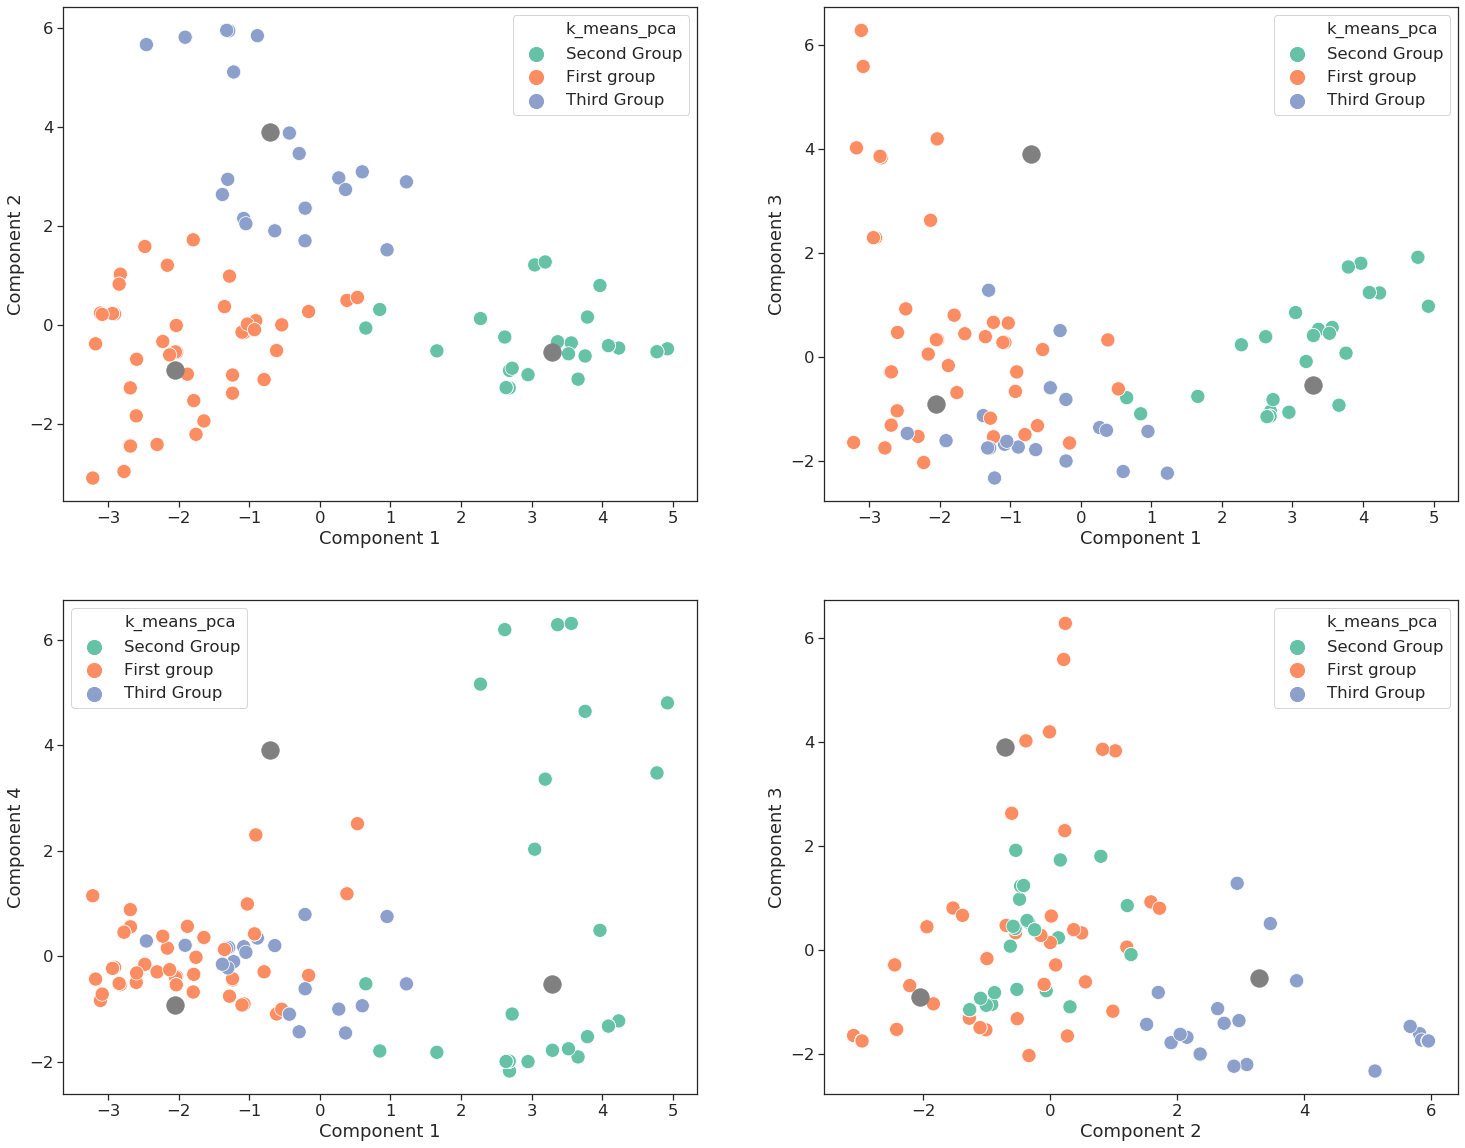

In [85]:
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group'})
fig = plt.figure(figsize = (25,20))
ax1 = fig.add_subplot(2,2,1)
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
#                palette = ['g', 'r', 'b'])

sns.scatterplot(x, y, hue = df_comp['k_means_pca'],
                size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

ax2 = fig.add_subplot(2,2,2)
x = df_comp['Component 1']
y = df_comp['Component 3']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'],
                size = df_comp['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

ax3 = fig.add_subplot(2,2,3)
x = df_comp['Component 1']
y = df_comp['Component 4']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], 
                size = df_comp['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

ax4 = fig.add_subplot(2,2,4)
x = df_comp['Component 2']
y = df_comp['Component 3']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

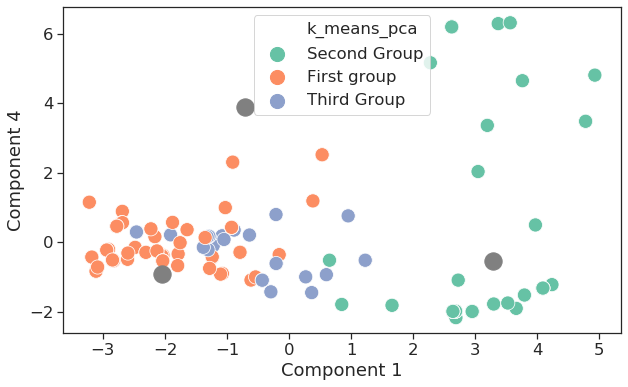

In [86]:
fig = plt.figure(figsize = (10,6))
x = df_comp['Component 1']
y = df_comp['Component 4']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

In [87]:
df_comp3 = df_comp.drop(['params.reactive_flow','params.real_gas', 
                                            'params.two_phase_flow', 'Component 1', 
                                            'Component 2', 'Component 3', 'Component 4'], axis = 1)
df_comp3.groupby('k_means_pca').mean()

params.ncell_group  params.smu2  vars.MPI_processes  \
k_means_pca                                                         
First group            43.409091     0.000000           98.784091   
Second Group           78.032787     0.819672          539.278689   
Third Group            84.137931     0.000000           97.620690   

              vars.dimension    vars.nodes  1S_C3H8_BFER  2S_propane  \
k_means_pca                                                            
First group         2.079545  2.065820e+05      0.011364    0.000000   
Second Group        3.000000  5.570854e+06      0.000000    0.000000   
Third Group         2.655172  9.182445e+05      0.068966    0.034483   

                   AIR  AIR_QPF_Vortex      C3H8  ...   jameson        no  \
k_means_pca                                       ...                       
First group   0.022727        0.034091  0.079545  ...  0.147727  0.568182   
Second Group  0.000000        0.000000  0.131148  ...  0.000000  0.000000   
Third Group   0.551724        0.000000  0.000000  ...  0.000000  0.034483   

                    LW     LW_FE     TTG4A      TTGC       DNS     sigma  \
k_means_pca                                                                
First group   0.420455  0.318182  0.068182  0.193182  0.943182  0.000000   
Second Group  0.098361  0.000000  0.000000  0.901639  0.016393  0.737705   
Third Group   0.965517  0.000000  0.000000  0.034483  0.034483  0.310345   

                 smago      wale  
k_means_pca                       
First group   0.056818  0.000000  
Second Group  0.049180  0.196721  
Third Group   0.620690  0.034483  

[3 rows x 42 columns]

In [88]:
df_comp3.groupby('k_means_pca').std()

params.ncell_group  params.smu2  vars.MPI_processes  \
k_means_pca                                                         
First group            12.944298     0.000000          100.413908   
Second Group           27.253114     0.428493          332.946048   
Third Group            68.113206     0.000000          205.547772   

              vars.dimension    vars.nodes  1S_C3H8_BFER  2S_propane  \
k_means_pca                                                            
First group         0.346463  4.744256e+05      0.106600    0.000000   
Second Group        0.000000  2.654505e+06      0.000000    0.000000   
Third Group         0.613879  1.822681e+06      0.257881    0.185695   

                   AIR  AIR_QPF_Vortex      C3H8  ...   jameson        no  \
k_means_pca                                       ...                       
First group   0.149887        0.182503  0.272139  ...  0.356863  0.498168   
Second Group  0.000000        0.000000  0.340363  ...  0.000000  0.000000   
Third Group   0.506120        0.000000  0.000000  ...  0.000000  0.185695   

                    LW    LW_FE     TTG4A      TTGC       DNS     sigma  \
k_means_pca                                                               
First group   0.496461  0.46844  0.253502  0.397057  0.232822  0.000000   
Second Group  0.300273  0.00000  0.000000  0.300273  0.128037  0.443533   
Third Group   0.185695  0.00000  0.000000  0.185695  0.185695  0.470824   

                 smago      wale  
k_means_pca                       
First group   0.232822  0.000000  
Second Group  0.218039  0.400819  
Third Group   0.493804  0.185695  

[3 rows x 42 columns]

In [89]:
dataframe = pd.concat([df_comp3[df_comp3['k_means_pca'] == 'First group'].mean(), 
                       df_comp3[df_comp3['k_means_pca'] == 'First group'].std(),
                       df_comp3[df_comp3['k_means_pca'] == 'Second Group'].mean(), 
                       df_comp3[df_comp3['k_means_pca'] == 'Second Group'].std(),
                       df_comp3[df_comp3['k_means_pca'] == 'Third Group'].mean(), 
                       df_comp3[df_comp3['k_means_pca'] == 'Third Group'].std()], axis = 1) 
dataframe.columns =  ['Mean First group', 'Std First Group', 
                      'Mean Second group', 'Std Second Group',
                      'Mean Third group', 'Std Third Group']
dataframe.sort_values(by ='Mean Second group', ascending = False)

Mean First group  Std First Group  Mean Second group  \
vars.nodes               206581.988636    474425.647054       5.570854e+06   
vars.MPI_processes           98.784091       100.413908       5.392787e+02   
params.ncell_group           43.409091        12.944298       7.803279e+01   
vars.dimension                2.079545         0.346463       3.000000e+00   
TTGC                          0.193182         0.397057       9.016393e-01   
params.smu2                   0.000000         0.000000       8.196721e-01   
colin                         0.284091         0.453565       7.540984e-01   
sigma                         0.000000         0.000000       7.377049e-01   
CH4                           0.227273         0.421472       4.426230e-01   
7.3.0                         0.443182         0.499608       4.262295e-01   
KERO_LUCHE                    0.000000         0.000000       4.262295e-01   
7.2.0                         0.352273         0.480416       3.934426e-01   
colin_species                 0.000000         0.000000       2.459016e-01   
wale                          0.000000         0.000000       1.967213e-01   
7.5.0                         0.125000         0.332614       1.639344e-01   
C3H8                          0.079545         0.272139       1.311475e-01   
LW                            0.420455         0.496461       9.836066e-02   
smago                         0.056818         0.232822       4.918033e-02   
DNS                           0.943182         0.232822       1.639344e-02   
7.6.0                         0.056818         0.232822       1.639344e-02   
colin_rhou_species            0.000000         0.000000       0.000000e+00   
1S_C3H8_BFER                  0.011364         0.106600       0.000000e+00   
2S_propane                    0.000000         0.000000       0.000000e+00   
TTG4A                         0.068182         0.253502       0.000000e+00   
LW_FE                         0.318182         0.468440       0.000000e+00   
no                            0.568182         0.498168       0.000000e+00   
jameson                       0.147727         0.356863       0.000000e+00   
honey                         0.000000         0.000000       0.000000e+00   
C3H8_23_274_10_PP             0.011364         0.106600       0.000000e+00   
colin_rhou                    0.000000         0.000000       0.000000e+00   
CH4_19_184_11_LU              0.011364         0.106600       0.000000e+00   
Jameson                       0.000000         0.000000       0.000000e+00   
7.4.0                         0.011364         0.106600       0.000000e+00   
AIR_QPF_Vortex                0.034091         0.182503       0.000000e+00   
7.1.0                         0.011364         0.106600       0.000000e+00   
N2_qpf_poiseuille_2D          0.022727         0.149887       0.000000e+00   
N2_qpf_poiseuille             0.022727         0.149887       0.000000e+00   
N2_qpf                        0.204545         0.405681       0.000000e+00   
C3H8_22_173_12_FC             0.000000         0.000000       0.000000e+00   
CH4_LU_19                     0.340909         0.476731       0.000000e+00   
CH4_53_634_0_GRI              0.011364         0.106600       0.000000e+00   
AIR                           0.022727         0.149887       0.000000e+00   

                      Std Second Group  Mean Third group  Std Third Group  
vars.nodes                2.654505e+06     918244.517241     1.822681e+06  
vars.MPI_processes        3.329460e+02         97.620690     2.055478e+02  
params.ncell_group        2.725311e+01         84.137931     6.811321e+01  
vars.dimension            0.000000e+00          2.655172     6.138789e-01  
TTGC                      3.002731e-01          0.034483     1.856953e-01  
params.smu2               4.284934e-01          0.000000     0.000000e+00  
colin                     4.341942e-01          0.241379     4.354942e-01  
sigma                     4.435328e-01          0.310345   


# Kmeans = 4

In [90]:
## PCA with 4 components
scaler = StandardScaler()
scaler.fit(df_pca)
scaled_data = scaler.transform(df_pca)
scaled_data
pca = PCA(n_components = 4)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)
#scores_pca
df_comp = pd.concat([df_pca.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_comp.columns.values[-4:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']
kmeans = KMeans(n_clusters = 4)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[1 2 0 0 3 1 1 2 1 3 2 0 2 2 0 1 0 2 2 1 2 1 2 1 2 2 2 2 2 2 3 3 1 2 1 3 3
 0 3 1 1 3 2 3 2 1 2 2 2 2 2 2 2 1 2 2 0 2 2 2 1 0 3 2 3 1 2 2 2 1 1 2 3 3
 2 3 2 2 2 3 2 3 1 3 2 2 3 2 1 3 1 2 3 2 1 2 2 1 2 1 1 2 2 0 1 1 1 0 1 2 2
 2 2 2 2 3 2 2 3 1 2 0 3 2 1 1 2 1 1 1 2 2 2 1 2 2 3 2 3 2 1 0 0 3 2 2 2 0
 1 1 1 1 2 2 0 2 2 3 1 1 2 3 2 1 2 3 0 1 2 2 2 2 2 0 2 1 2 2]


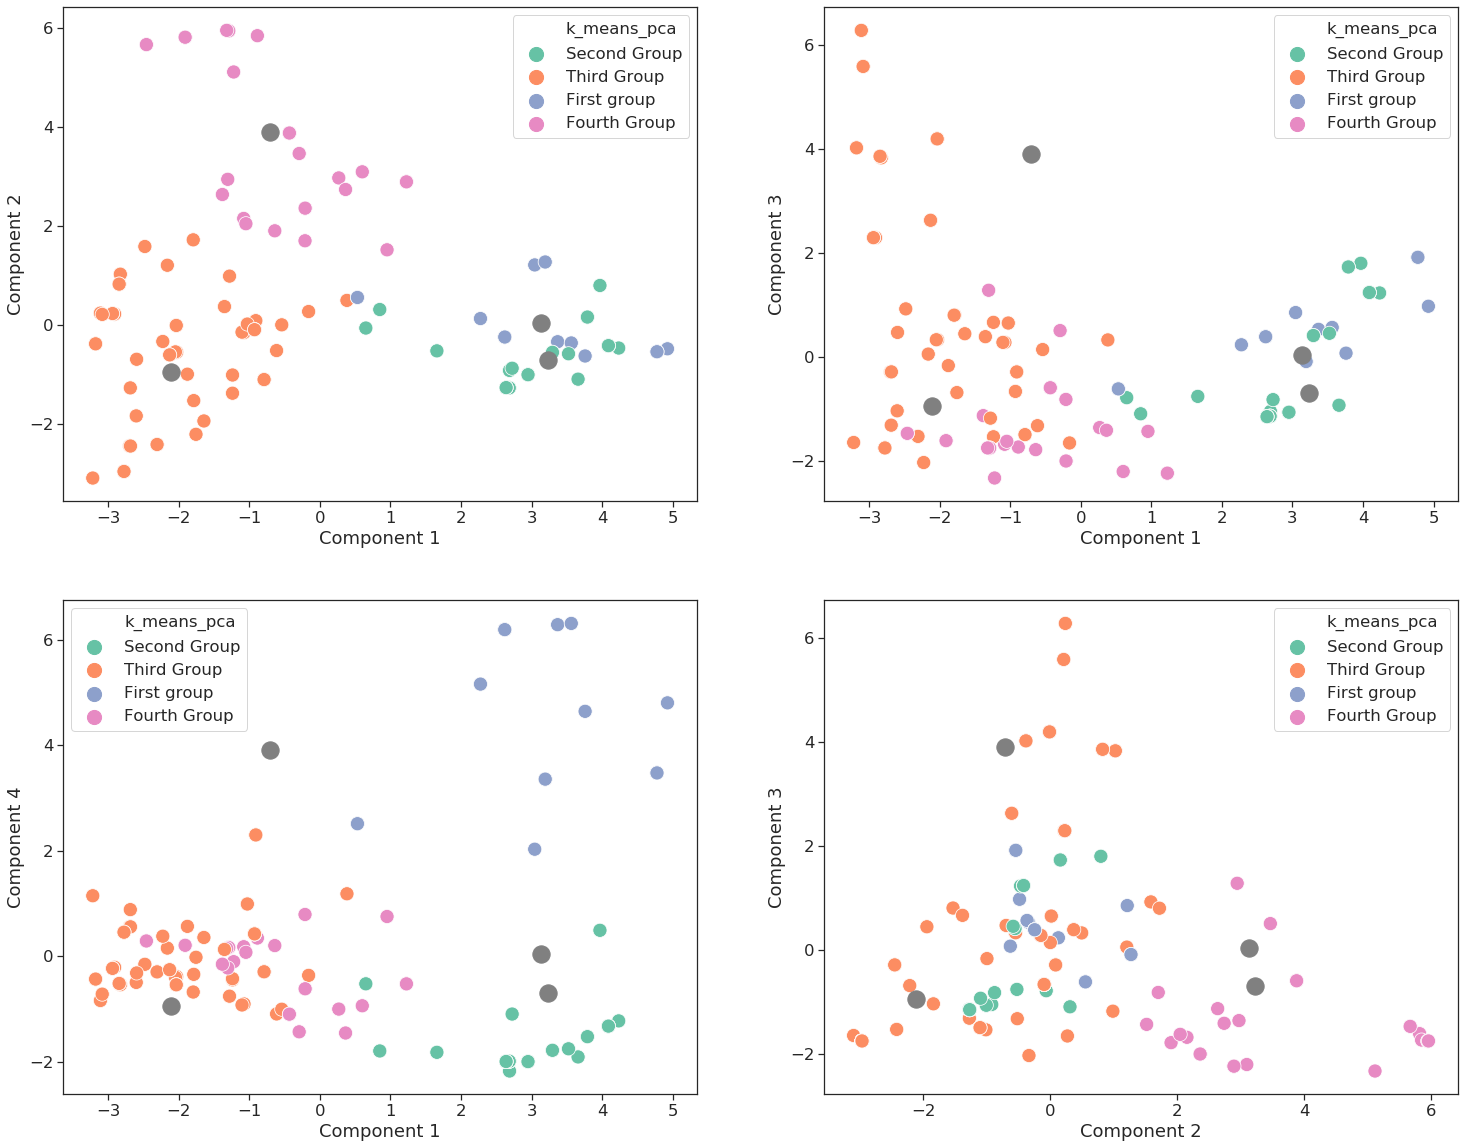

In [91]:
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group', 
                                                     3: 'Fourth Group'})

fig = plt.figure(figsize = (25,20))
ax1 = fig.add_subplot(2,2,1)
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
#                palette = ['g', 'r', 'b'])

sns.scatterplot(x, y, hue = df_comp['k_means_pca'],
                size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

ax2 = fig.add_subplot(2,2,2)
x = df_comp['Component 1']
y = df_comp['Component 3']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'],
                size = df_comp['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

ax3 = fig.add_subplot(2,2,3)
x = df_comp['Component 1']
y = df_comp['Component 4']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], 
                size = df_comp['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

ax4 = fig.add_subplot(2,2,4)
x = df_comp['Component 2']
y = df_comp['Component 3']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

In [92]:
df_comp = df_comp.drop(['params.reactive_flow','params.real_gas', 
                                            'params.two_phase_flow', 'Component 1', 
                                            'Component 2', 'Component 3', 'Component 4'], axis = 1)
df_comp.groupby('k_means_pca').mean()

params.ncell_group  params.smu2  vars.MPI_processes  \
k_means_pca                                                         
First group            76.470588     0.411765          758.352941   
Fourth Group           84.137931     0.000000           97.620690   
Second Group           77.826087     0.934783          436.434783   
Third Group            43.023256     0.000000          100.244186   

              vars.dimension    vars.nodes  1S_C3H8_BFER  2S_propane  \
k_means_pca                                                            
First group         2.882353  5.733487e+06      0.000000    0.000000   
Fourth Group        2.655172  9.182445e+05      0.068966    0.034483   
Second Group        3.000000  5.269943e+06      0.000000    0.000000   
Third Group         2.081395  2.106352e+05      0.011628    0.000000   

                   AIR  AIR_QPF_Vortex      C3H8  ...   jameson        no  \
k_means_pca                                       ...                       
First group   0.000000        0.000000  0.588235  ...  0.000000  0.000000   
Fourth Group  0.551724        0.000000  0.000000  ...  0.000000  0.034483   
Second Group  0.000000        0.000000  0.000000  ...  0.000000  0.000000   
Third Group   0.023256        0.034884  0.058140  ...  0.151163  0.581395   

                    LW     LW_FE     TTG4A      TTGC       DNS     sigma  \
k_means_pca                                                                
First group   0.176471  0.000000  0.000000  0.823529  0.000000  0.000000   
Fourth Group  0.965517  0.000000  0.000000  0.034483  0.034483  0.310345   
Second Group  0.065217  0.000000  0.000000  0.934783  0.021739  0.978261   
Third Group   0.430233  0.325581  0.069767  0.174419  0.965116  0.000000   

                 smago      wale  
k_means_pca                       
First group   0.294118  0.705882  
Fourth Group  0.620690  0.034483  
Second Group  0.000000  0.000000  
Third Group   0.034884  0.000000  

[4 rows x 42 columns]

In [93]:
dataframe = pd.concat([df_comp[df_comp['k_means_pca'] == 'First group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'First group'].std(),
                       df_comp[df_comp['k_means_pca'] == 'Second Group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'Second Group'].std(),
                       df_comp[df_comp['k_means_pca'] == 'Third Group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'Third Group'].std(),
                       df_comp[df_comp['k_means_pca'] == 'Fourth Group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'Fourth Group'].std()], axis = 1) 
dataframe.columns =  ['Mean First group', 'Std First Group', 
                      'Mean Second group', 'Std Second Group',
                      'Mean Third group', 'Std Third Group',
                     'Mean Fourth group', 'Mean Fourth Group']
dataframe.sort_values(by ='Mean Third group', ascending = False)

Mean First group  Std First Group  Mean Second group  \
vars.nodes                5.733487e+06     3.462337e+06       5.269943e+06   
vars.MPI_processes        7.583529e+02     3.943274e+02       4.364348e+02   
params.ncell_group        7.647059e+01     2.029199e+01       7.782609e+01   
vars.dimension            2.882353e+00     3.321056e-01       3.000000e+00   
DNS                       0.000000e+00     0.000000e+00       2.173913e-02   
no                        0.000000e+00     0.000000e+00       0.000000e+00   
7.3.0                     2.352941e-01     4.372373e-01       4.782609e-01   
LW                        1.764706e-01     3.929526e-01       6.521739e-02   
7.2.0                     0.000000e+00     0.000000e+00       5.217391e-01   
CH4_LU_19                 0.000000e+00     0.000000e+00       0.000000e+00   
LW_FE                     0.000000e+00     0.000000e+00       0.000000e+00   
colin                     1.764706e-01     3.929526e-01       9.782609e-01   
CH4                       0.000000e+00     0.000000e+00       5.869565e-01   
N2_qpf                    0.000000e+00     0.000000e+00       0.000000e+00   
TTGC                      8.235294e-01     3.929526e-01       9.347826e-01   
jameson                   0.000000e+00     0.000000e+00       0.000000e+00   
7.5.0                     7.058824e-01     4.696682e-01       0.000000e+00   
TTG4A                     0.000000e+00     0.000000e+00       0.000000e+00   
C3H8                      5.882353e-01     5.072997e-01       0.000000e+00   
7.6.0                     5.882353e-02     2.425356e-01       0.000000e+00   
AIR_QPF_Vortex            0.000000e+00     0.000000e+00       0.000000e+00   
smago                     2.941176e-01     4.696682e-01       0.000000e+00   
AIR                       0.000000e+00     0.000000e+00       0.000000e+00   
N2_qpf_poiseuille_2D      0.000000e+00     0.000000e+00       0.000000e+00   
N2_qpf_poiseuille         0.000000e+00     0.000000e+00       0.000000e+00   
7.1.0                     0.000000e+00     0.000000e+00       0.000000e+00   
7.4.0                     0.000000e+00     0.000000e+00       0.000000e+00   
1S_C3H8_BFER              0.000000e+00     0.000000e+00       0.000000e+00   
C3H8_23_274_10_PP         0.000000e+00     0.000000e+00       0.000000e+00   
CH4_19_184_11_LU          0.000000e+00     0.000000e+00       0.000000e+00   
CH4_53_634_0_GRI          0.000000e+00     0.000000e+00       0.000000e+00   
sigma                     0.000000e+00     0.000000e+00       9.782609e-01   
2S_propane                0.000000e+00     0.000000e+00       0.000000e+00   
honey                     0.000000e+00     0.000000e+00       0.000000e+00   
KERO_LUCHE                4.117647e-01     5.072997e-01       4.130435e-01   
params.smu2               4.117647e-01     5.072997e-01       9.347826e-01   
colin_species             8.235294e-01     3.929526e-01       2.173913e-02   
colin_rhou_species        0.000000e+00     0.000000e+00       0.000000e+00   
colin_rhou                0.000000e+00     0.000000e+00       0.000000e+00   
Jameson                   0.000000e+00     0.000000e+00       0.000000e+00   
C3H8_22_173_12_FC         0.000000e+00     0.000000e+00       0.000000e+00   
wale                      7.058824e-01     4.696682e-01       0.000000e+00   

                      Std Second Group  Mean Third group  Std Third Group  \
vars.nodes                2.528573e+06     210635.174419    479212.205049   
vars.MPI_processes        2.735540e+02        100.244186       101.120189   
params.ncell_group        2.928124e+01         43.023256        12.840173   
vars.dimension            0.000000e+00          2.081395         0.350298   
DNS                       1.474420e-01          0.965116         0.184561   
no                        0.000000e+00          0.581395         0.496224   
7.3.0                     5.050470e-01          0.453488         0.500752   
LW                        2.496374e-01          0.4